This notebook implements the clustering of the TCR Clonotypes

In [14]:
import numpy as np
import pandas as pd

import scanpy as scp

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import sklearn as sk
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import normalize

from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    pair_confusion_matrix,
)

from sklearn.metrics.pairwise import cosine_similarity

from skbio.stats.composition import ilr, multi_replace

from functools import reduce

from scipy import sparse

from scipy.spatial.distance import pdist, squareform

from sklearn.preprocessing import StandardScaler

import os

import warnings

%load_ext jupyter_black

import warnings

warnings.simplefilter("ignore", category=UserWarning)


#runs the specified clustering algorithm and saves the obtained clonotypes as a column in the adata file
def run_and_plot_clustering(
    data,
    n_clusters=4,
    seed=0,
    method="kmeans",
    affinity="precomputed",
    gamma=1.5e-2,
    hard=True,
):

    if method == "kmeans":
        c_alg = KMeans(
            n_clusters=n_clusters,
            max_iter=100,
            n_init=20,
            random_state=seed,
        ).fit(data)
    elif method == "spectral":
        c_alg = SpectralClustering(
            n_clusters=n_clusters,
            affinity=affinity,
            assign_labels="cluster_qr",
            random_state=seed,
            gamma=gamma,
        ).fit(data)
    else:
        c_alg = GaussianMixture(
            n_components=n_clusters, n_init=20, random_state=seed
        ).fit(data)

    for clonotype_cluster in range(n_clusters):

        clonotypes_in_cluster = data.index[c_alg.labels_ == clonotype_cluster]

        cluster_mask = reduce(
            lambda a, b: a | b,
            [
                (adata.obs["Clonotype"] == clonotype).values
                for clonotype in clonotypes_in_cluster
            ],
        )

        adata.obs.loc[cluster_mask, "Clonotype cluster"] = clonotype_cluster

    count_df_ = (
        adata.obs.value_counts(["Clonotype cluster", "Cluster label"])
        .reset_index()
        .pivot(index="Clonotype cluster", columns="Cluster label", values="count")
    ).fillna(0)
    count_df_.plot.barh(stacked=True)
    plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
    plt.show()

    count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
    count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
    count_df__norm.plot.barh(stacked=True)
    plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
    plt.show()

    return c_alg

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [15]:
# Load preprocessed adata
adata = scp.read("adata_CD8_velocity_all.h5ad")
print(adata.shape)

tcr_adata = scp.read("TCR_data_test.h5ad")
print(tcr_adata.shape)

# preprocess
# remove patient LHCC48
adata = adata[adata.obs.index[adata.obs.Patient != "LHCC48"]]

# add tcr clonotypes to main adata
adata.obs["Clonotype"] = pd.Categorical(
    [
        tcr_adata.obs.loc[idx]["clone_id"] if idx in tcr_adata.obs.index else pd.NA
        for idx, cell in adata.obs.iterrows()
    ]
)

adata.obs["Clonotype size"] = pd.Categorical(
    [
        (tcr_adata.obs.loc[idx]["clone_id_size"] if idx in tcr_adata.obs.index else 0)
        for idx, cell in adata.obs.iterrows()
    ]
)

(11766, 7109)
(4962, 0)


In [16]:
adata.obs["Clonotype"] = tcr_adata.obs["clone_id"]
adata.obs["Clonotype size"] = tcr_adata.obs["clone_id_size"]

In [17]:
tcr_adata.obs[(tcr_adata.obs["clone_id_size"] > 5)]

,receptor_type,receptor_subtype,chain_pairing,clone_id,clone_id_size,clonal_expansion
ACCTTTACAGCCTTGG_LHCC40_Control_CD45,TCR,TRA+TRB,single pair,35,6,> 2
ACTTTCATCCAGATCA_LHCC40_Control_CD45,TCR,TRA+TRB,single pair,37,7,> 2
CCTTTCTGTGGGTCAA_LHCC40_Control_CD45,TCR,TRA+TRB,single pair,40,11,> 2
TCAGATGGTTCGCGAC_LHCC40_Control_CD45,TCR,TRA+TRB,single pair,50,8,> 2
CTCGGGATCACCACCT_LHCC40_Core_CD45,TCR,TRA+TRB,extra VJ,40,11,> 2
...,...,...,...,...,...,...
TTCTACAAGTGGCACA_LHCC54_Control_CD45,TCR,TRA+TRB,single pair,740,11,> 2
CTCGTCATCTTTAGGG_LHCC54_Core_CD45,TCR,TRA+TRB,single pair,740,11,> 2
GACTACATCGGGAGTA_LHCC54_Core_CD45,TCR,TRA+TRB,single pair,1460,11,> 2
GAGTCCGTCTTAACCT_LHCC54_Core_CD45,TCR,TRA+TRB,single pair,222,11,> 2


In [18]:
adata_w_tcr = adata[adata.obs["Clonotype"].notnull()]

for clonotype in adata_w_tcr.obs["Clonotype"].unique():
    patients = (
        adata_w_tcr[adata_w_tcr.obs["Clonotype"] == clonotype].obs["Patient"].unique()
    )
    if len(patients) > 1:
        print(clonotype, len(patients))

# no print => all Clonotypes are private

In [19]:
# Look at and plot some clonotype statistics
adata_w_tcr = adata[adata.obs["Clonotype size"] > 5]
adata_w_tcr.obs["Clonotype"].unique()

['245', '751', '315', '278', '281', ..., '1464', '1461', '1462', '736', '228']
Length: 146
Categories (146, object): ['35', '37', '40', '50', ..., '1461', '1462', '1464', '1660']

In [20]:
tissue_types = []

for clonotype in adata_w_tcr.obs["Clonotype"].unique():
    tissue = (
        adata_w_tcr[adata_w_tcr.obs["Clonotype"] == clonotype].obs["Tissue"].unique()
    )
    tissue_types.append(len(tissue))


# all Clonotypes are private

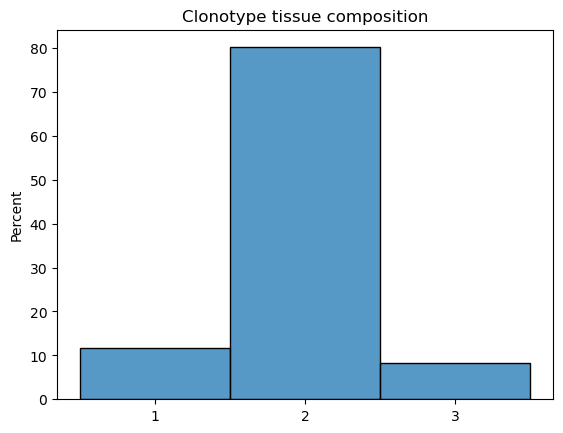

In [21]:
ax = sns.histplot(tissue_types, discrete=True, stat="percent")
ax.set_title("Clonotype tissue composition")
ax = ax.set_xticks(ticks=[1, 2, 3], labels=[1, 2, 3])

In [22]:
celltype_counts = []

for clonotype in adata_w_tcr.obs["Clonotype"].unique():
    cl = (
        adata_w_tcr[adata_w_tcr.obs["Clonotype"] == clonotype]
        .obs["Cluster label"]
        .unique()
    )
    celltype_counts.append(len(cl))

In [23]:
len(adata_w_tcr.obs["Cluster label"].unique())

8

Text(0.5, 1.0, 'Clonotype cell type composition')

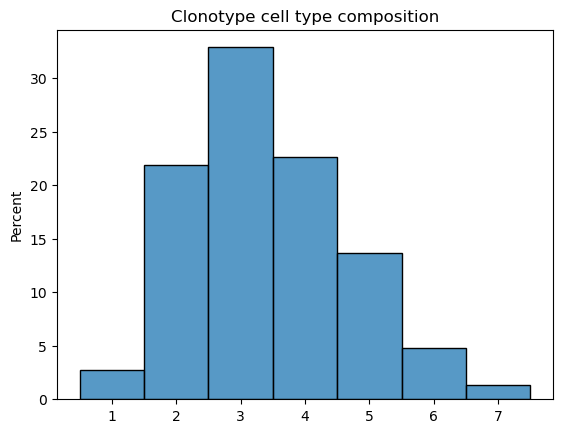

In [24]:
ax = sns.histplot(celltype_counts, discrete=True, stat="percent")
ax.set_title("Clonotype cell type composition")
# ax = ax.set_xticks(ticks=range(1, 8), labels=range(1, 8))

In [25]:
# get patients per clonotype
clonotype_patients = (
    adata.obs.groupby("Clonotype", observed=True)["Patient"].unique().values
)

clonotype_patients = pd.Series([p[0] for p in clonotype_patients])

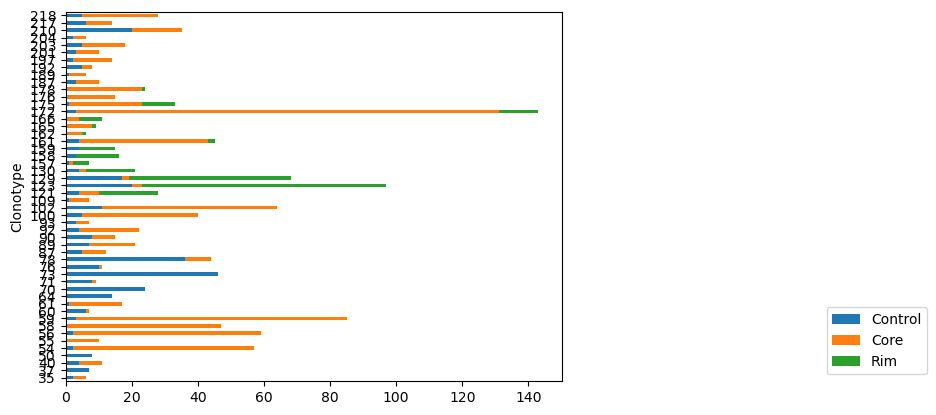

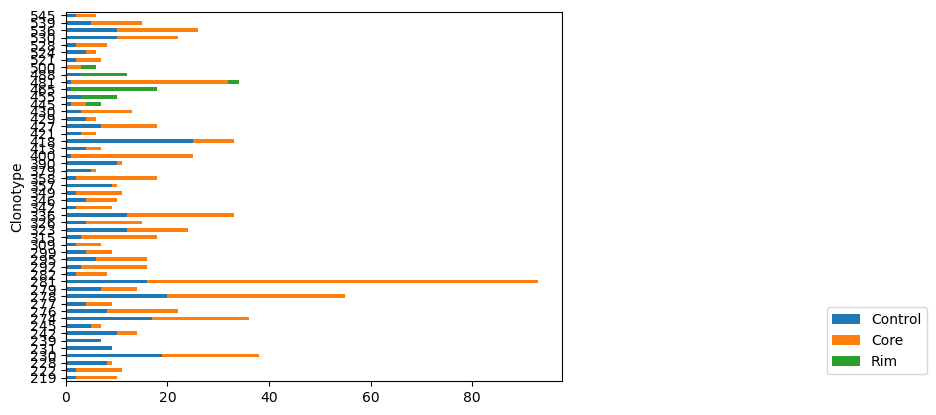

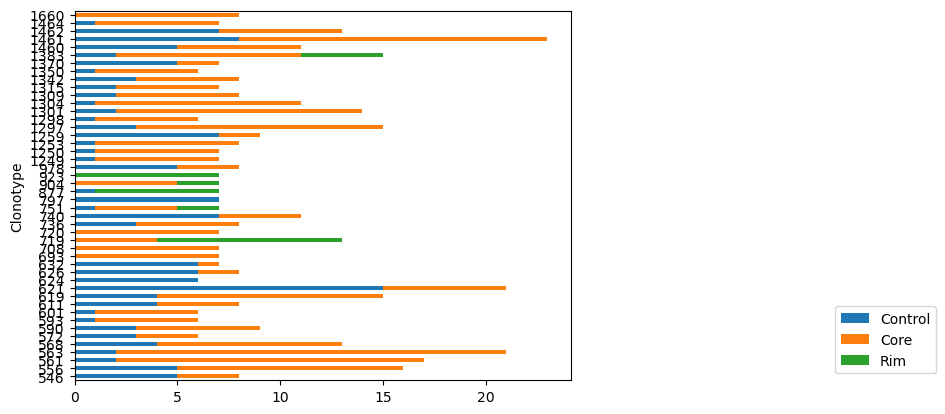

In [26]:
clonotype_count_df = (
    adata_w_tcr.obs.value_counts(["Clonotype", "Tissue"])
    .reset_index()
    .pivot(index="Clonotype", columns="Tissue", values="count")
).fillna(0)

clonotype_count_df.iloc[:50, :].plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

clonotype_count_df.iloc[50:100, :].plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

clonotype_count_df.iloc[100:, :].plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

In [27]:
clonotype_count_df = (
    adata.obs.value_counts(["Clonotype", "Cluster label"])
    .reset_index()
    .pivot(index="Clonotype", columns="Cluster label", values="count")
).fillna(0)

In [28]:
clonotype_sizes = clonotype_count_df.sum(axis=1)

In [29]:
clonotype_sizes

Clonotype
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1759    1.0
1760    1.0
1761    1.0
1762    1.0
1763    1.0
Length: 1764, dtype: float64

In [30]:
clonotype_sizes.max()

143.0

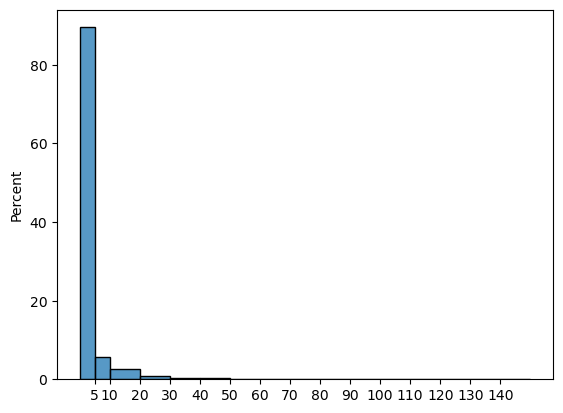

In [31]:
bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
ax = sns.histplot(clonotype_sizes, bins=bins, stat="percent")

ax = ax.set_xticks(ticks=bins[1:-1], labels=bins[1:-1])

In [32]:
THRESHOLD = 5
clonotype_count_df = clonotype_count_df[clonotype_sizes > THRESHOLD]
clonotype_patients = clonotype_patients[(clonotype_sizes > THRESHOLD).values]
clonotype_sizes = clonotype_count_df.sum(axis=1)

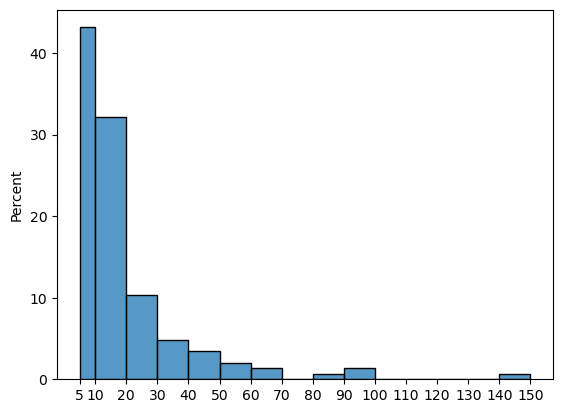

In [33]:
bins = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
ax = sns.histplot(clonotype_sizes, bins=bins, stat="percent")

ax = ax.set_xticks(ticks=bins, labels=bins)

In [34]:
clonotype_sizes.shape

(146,)

In [35]:
clonotype_sizes.sum()

2630.0

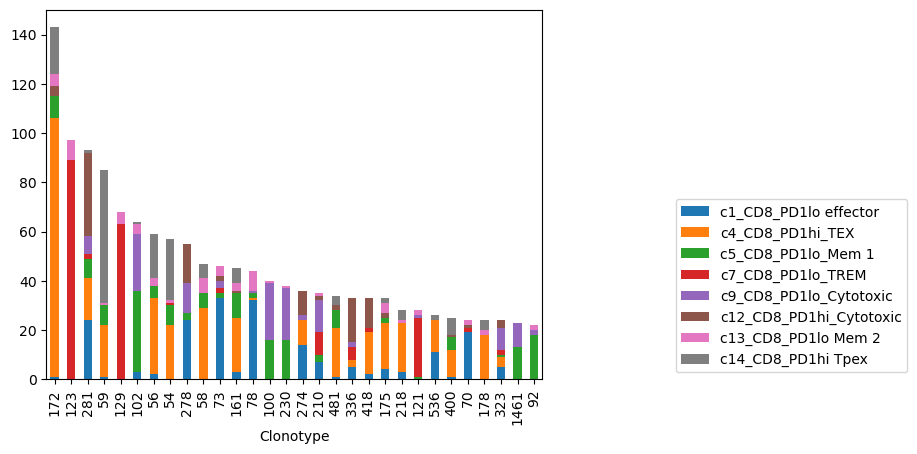

In [32]:
top_clonotypes = clonotype_count_df.sum(axis=1).sort_values(ascending=False)[:30].index
clonotype_count_df_small = clonotype_count_df.loc[top_clonotypes]

clonotype_count_df_small.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

In [37]:
# L2 normalize count vectors
_, array_norms = normalize(clonotype_count_df, norm="l2", axis=1, return_norm=True)
clonotype_count_df_normed = clonotype_count_df.div(array_norms, axis=0)  # normalize

In [213]:
# L1 normalize count vectors
clonotype_count_df_l1 = clonotype_count_df.div(clonotype_sizes, axis=0)

In [89]:
# Apply Isometric Log-Ratio_transform
clonotype_count_df_l1_corrected = pd.DataFrame(
    data=multi_replace(clonotype_count_df_l1), index=clonotype_count_df.index
) # replace 0s 

clonotype_count_df_logged = ilr(clonotype_count_df_l1_corrected)
clonotype_count_df_logged = pd.DataFrame(
    data=clonotype_count_df_logged, index=clonotype_count_df.index
)

In [ ]:
# Compute cosine similarity
similarity = pd.DataFrame(
    cosine_similarity(clonotype_count_df_l1),
    columns=clonotype_count_df_l1.index,
    index=clonotype_count_df_l1.index,
)

## Run the clustering algorithms

Clusters: 2
Clusters: 3
Clusters: 4
Clusters: 5
Clusters: 6
Clusters: 7
Clusters: 8
Clusters: 9
Clusters: 10
Clusters: 11
Clusters: 12


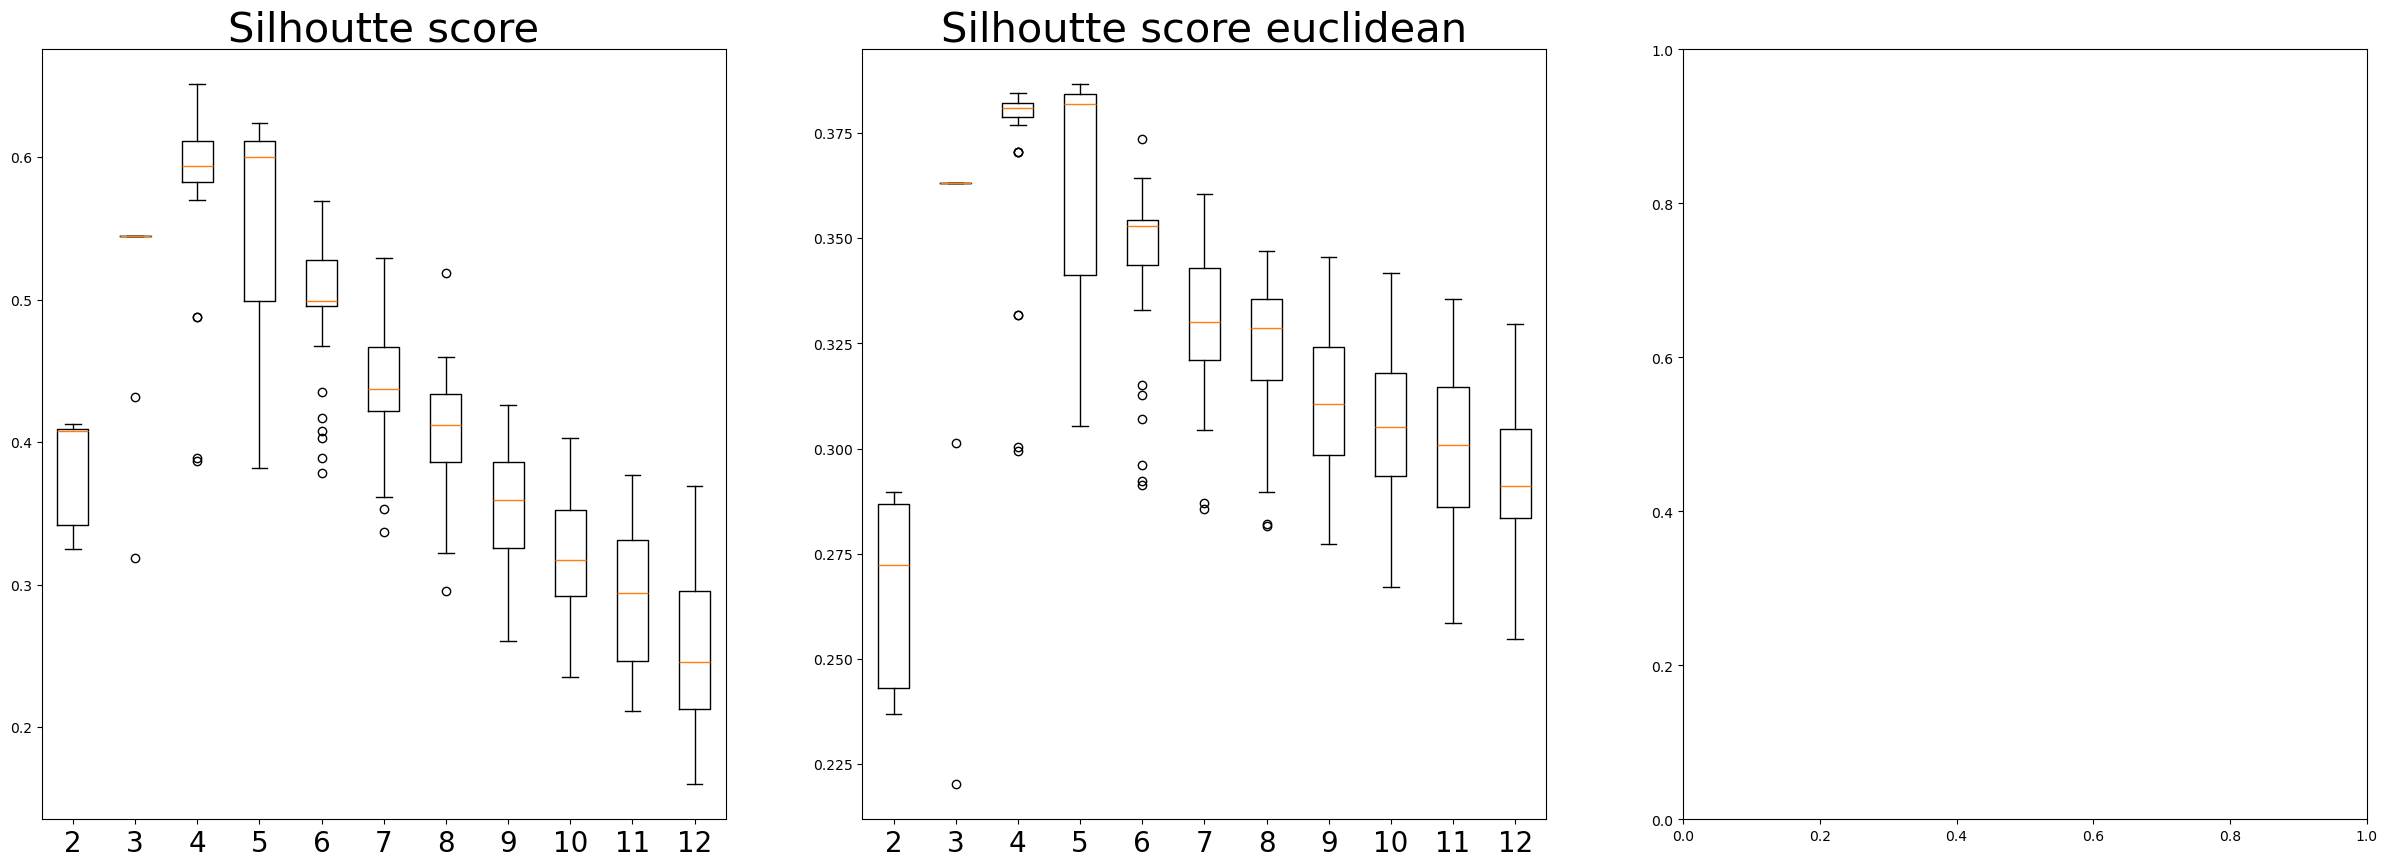

In [227]:
result_dict_kmeans_ilr = {
    "Silhoutte score": [],
    "Silhoutte score euclidean": [],
}

for n_clusters in range(2, 13):
    print(f"Clusters: {n_clusters}")
    silhouettes = []
    silhouettes_euclidean = []
    for seed in range(50):
        kmeans = KMeans(n_clusters=n_clusters, max_iter=100, random_state=seed).fit(
            clonotype_count_df_logged
        )

        cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
        # print(f"\tNumber of elements assigned to each cluster: {cluster_sizes}")

        silhouette = silhouette_score(
            clonotype_count_df, kmeans.labels_, metric="cosine"
        )

        silhouettes.append(silhouette)

        silhouette = silhouette_score(
            clonotype_count_df_logged, kmeans.labels_, metric="euclidean"
        )

        silhouettes_euclidean.append(silhouette)

    result_dict_kmeans_ilr["Silhoutte score"].append(silhouettes)
    result_dict_kmeans_ilr["Silhoutte score euclidean"].append(silhouettes_euclidean)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(30, 10))

for i, (key, item) in enumerate(result_dict_kmeans_ilr.items()):
    axes[i].boxplot(x=item)
    axes[i].set_title(key, fontsize=30)

    labels = [str(x) for x in range(2, 13)]
    axes[i].set_xticklabels(labels, fontsize=20)

Clusters: 2
Clusters: 3
Clusters: 4
Clusters: 5
Clusters: 6
Clusters: 7
Clusters: 8
Clusters: 9
Clusters: 10
Clusters: 11
Clusters: 12


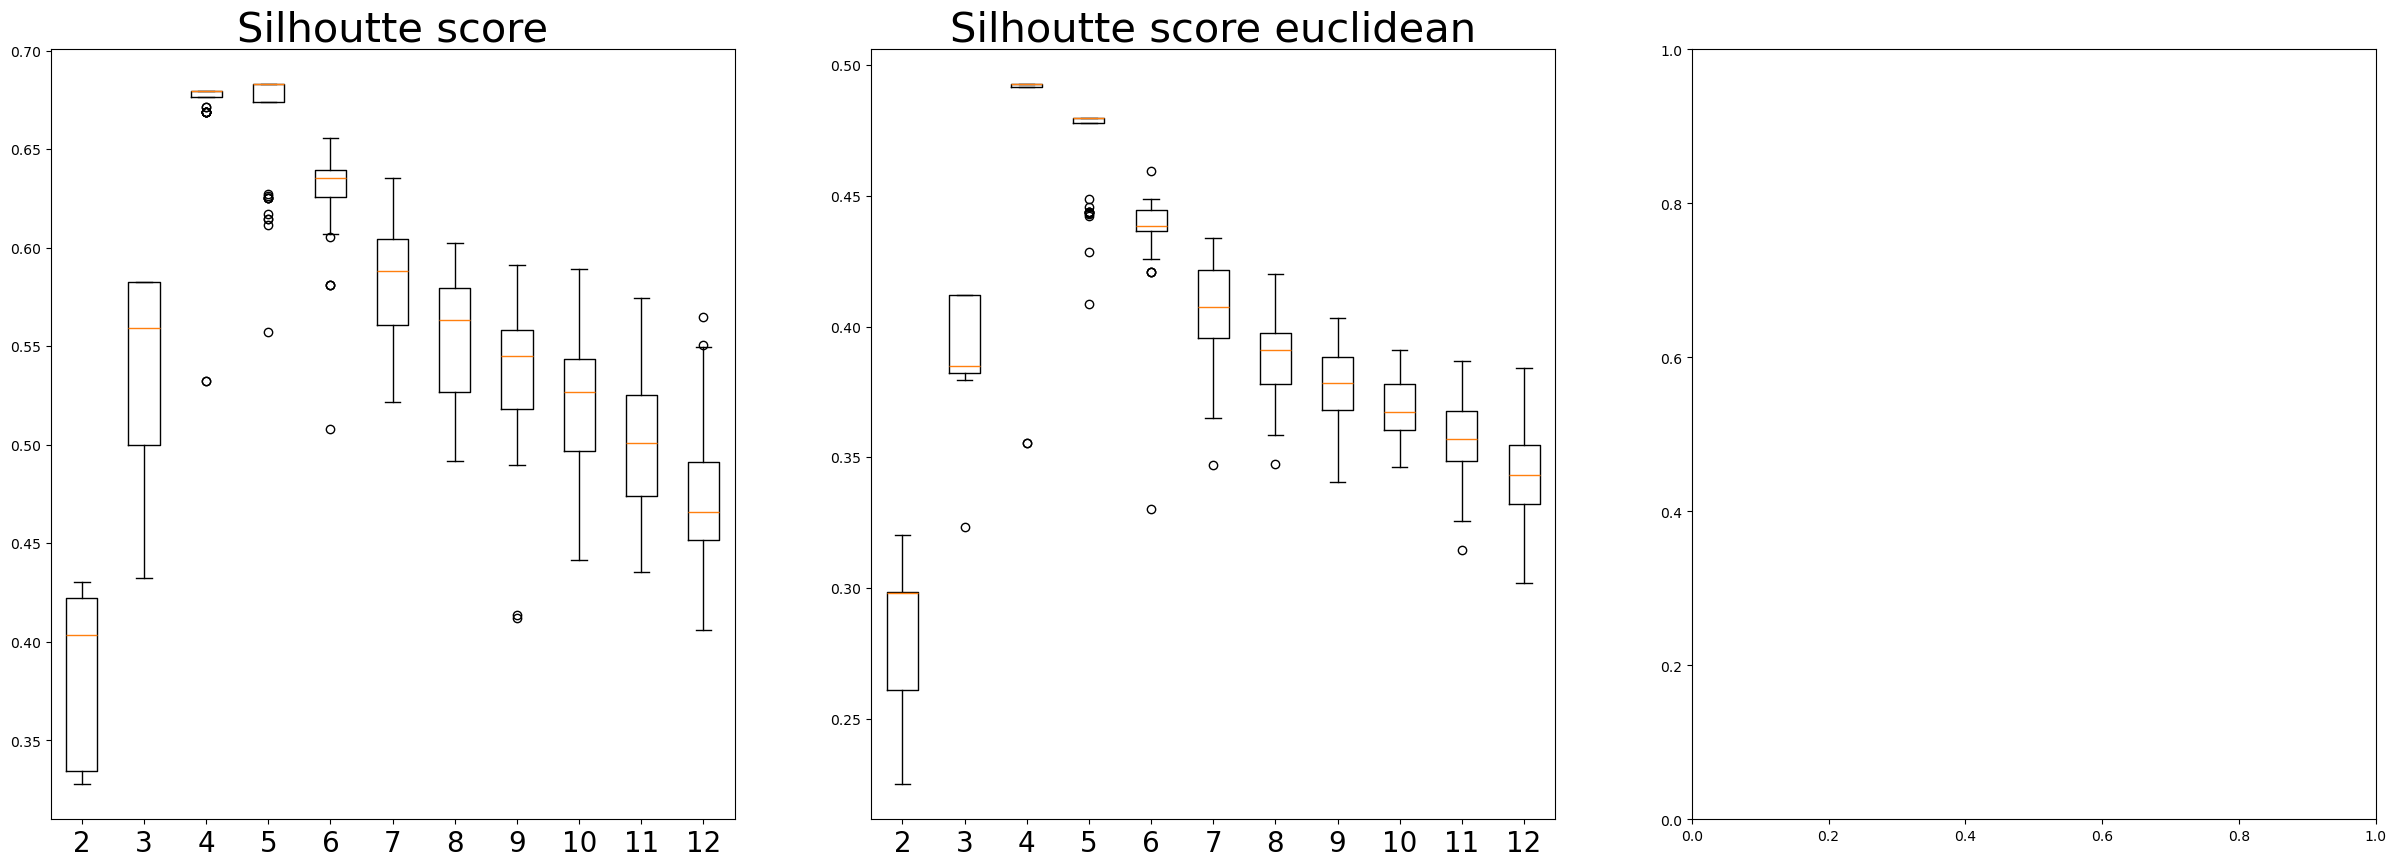

In [228]:
result_dict_kmeans_l1 = {
    "Silhoutte score": [],
    "Silhoutte score euclidean": [],
}

for n_clusters in range(2, 13):
    print(f"Clusters: {n_clusters}")
    silhouettes = []
    silhouettes_euclidean = []
    for seed in range(50):
        kmeans = KMeans(n_clusters=n_clusters, max_iter=100, random_state=seed).fit(
            clonotype_count_df_l1
        )

        cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
        # print(f"\tNumber of elements assigned to each cluster: {cluster_sizes}")

        silhouette = silhouette_score(
            clonotype_count_df_l1, kmeans.labels_, metric="cosine"
        )

        silhouettes.append(silhouette)

        silhouette = silhouette_score(
            clonotype_count_df_l1, kmeans.labels_, metric="euclidean"
        )

        silhouettes_euclidean.append(silhouette)

    result_dict_kmeans_l1["Silhoutte score"].append(silhouettes)
    result_dict_kmeans_l1["Silhoutte score euclidean"].append(silhouettes_euclidean)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(30, 10))

for i, (key, item) in enumerate(result_dict_kmeans_l1.items()):
    axes[i].boxplot(x=item)
    axes[i].set_title(key, fontsize=30)

    labels = [str(x) for x in range(2, 13)]
    axes[i].set_xticklabels(labels, fontsize=20)

Clusters: 2
Clusters: 3
Clusters: 4
Clusters: 5
Clusters: 6
Clusters: 7
Clusters: 8
Clusters: 9
Clusters: 10
Clusters: 11
Clusters: 12


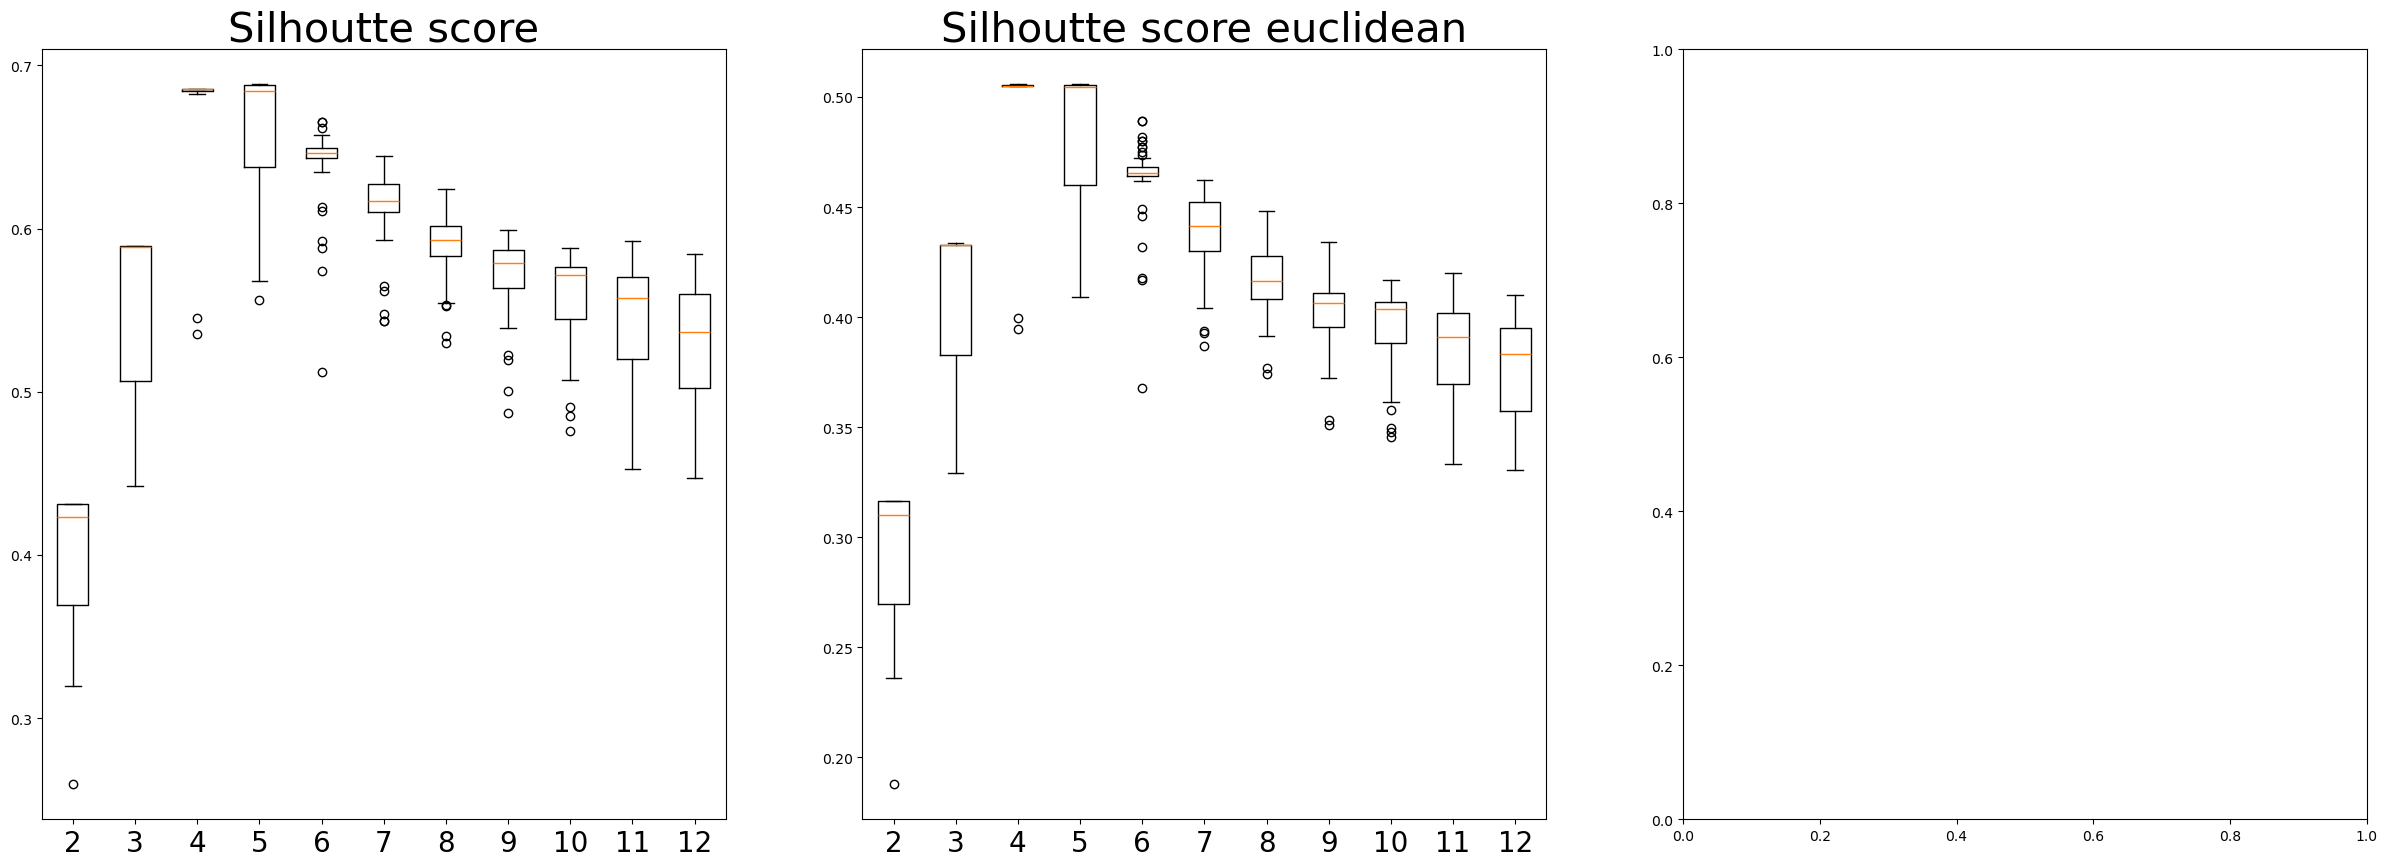

In [229]:
result_dict_kmeans_l2 = {
    "Silhoutte score": [],
    "Silhoutte score euclidean": [],
}

for n_clusters in range(2, 13):
    print(f"Clusters: {n_clusters}")
    silhouettes = []
    silhouettes_euclidean = []
    for seed in range(50):
        kmeans = KMeans(n_clusters=n_clusters, max_iter=100, random_state=seed).fit(
            clonotype_count_df_normed
        )

        cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
        # print(f"\tNumber of elements assigned to each cluster: {cluster_sizes}")

        silhouette = silhouette_score(
            clonotype_count_df_normed, kmeans.labels_, metric="cosine"
        )

        silhouettes.append(silhouette)

        silhouette = silhouette_score(
            clonotype_count_df_normed, kmeans.labels_, metric="euclidean"
        )

        silhouettes_euclidean.append(silhouette)

    result_dict_kmeans_l2["Silhoutte score"].append(silhouettes)
    result_dict_kmeans_l2["Silhoutte score euclidean"].append(silhouettes_euclidean)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(30, 10))

for i, (key, item) in enumerate(result_dict_kmeans_l2.items()):
    axes[i].boxplot(x=item)
    axes[i].set_title(key, fontsize=30)

    labels = [str(x) for x in range(2, 13)]
    axes[i].set_xticklabels(labels, fontsize=20)

Clusters: 2
Clusters: 3
Clusters: 4
Clusters: 5
Clusters: 6
Clusters: 7
Clusters: 8
Clusters: 9
Clusters: 10
Clusters: 11
Clusters: 12


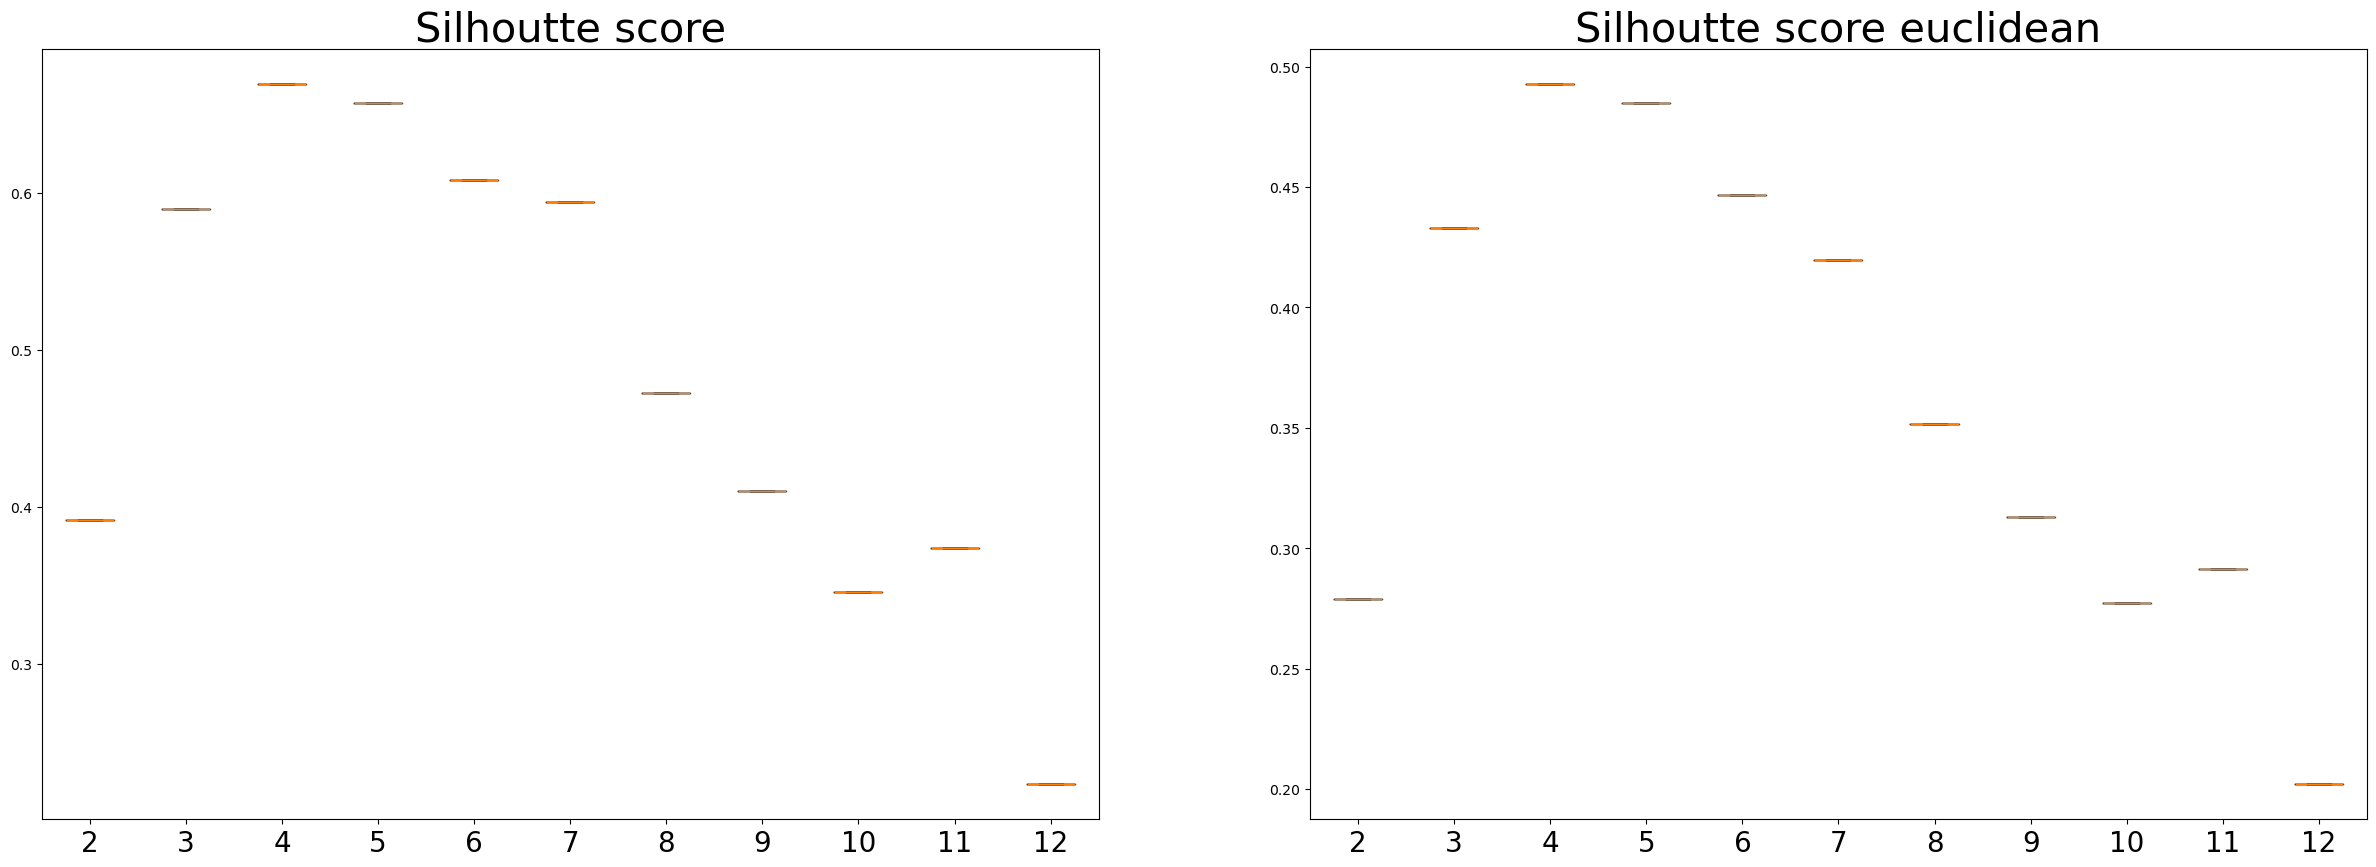

In [230]:
result_dict_spectral_rbf_l2 = {
    "Silhoutte score": [],
    "Silhoutte score euclidean": [],
}

for n_clusters in range(2, 13):
    print(f"Clusters: {n_clusters}")
    silhouettes = []
    silhouettes_euclidean = []
    for seed in range(50):
        kmeans = SpectralClustering(
            n_clusters=n_clusters,
            affinity="rbf",
            assign_labels="cluster_qr",
            gamma=1.5e-2,
            random_state=seed,
        ).fit(clonotype_count_df_normed)

        cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

        silhouette = silhouette_score(
            clonotype_count_df_normed, kmeans.labels_, metric="cosine"
        )

        silhouettes.append(silhouette)

        silhouette = silhouette_score(
            clonotype_count_df_normed, kmeans.labels_, metric="euclidean"
        )
        silhouettes_euclidean.append(silhouette)

    result_dict_spectral_rbf_l2["Silhoutte score"].append(silhouettes)
    result_dict_spectral_rbf_l2["Silhoutte score euclidean"].append(
        silhouettes_euclidean
    )

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(30, 10))

for i, (key, item) in enumerate(result_dict_spectral_rbf_l2.items()):
    axes[i].boxplot(x=item)
    axes[i].set_title(key, fontsize=30)

    labels = [str(x) for x in range(2, 13)]
    axes[i].set_xticklabels(labels, fontsize=20)

Clusters: 2
Clusters: 3
Clusters: 4
Clusters: 5
Clusters: 6
Clusters: 7
Clusters: 8
Clusters: 9
Clusters: 10
Clusters: 11
Clusters: 12


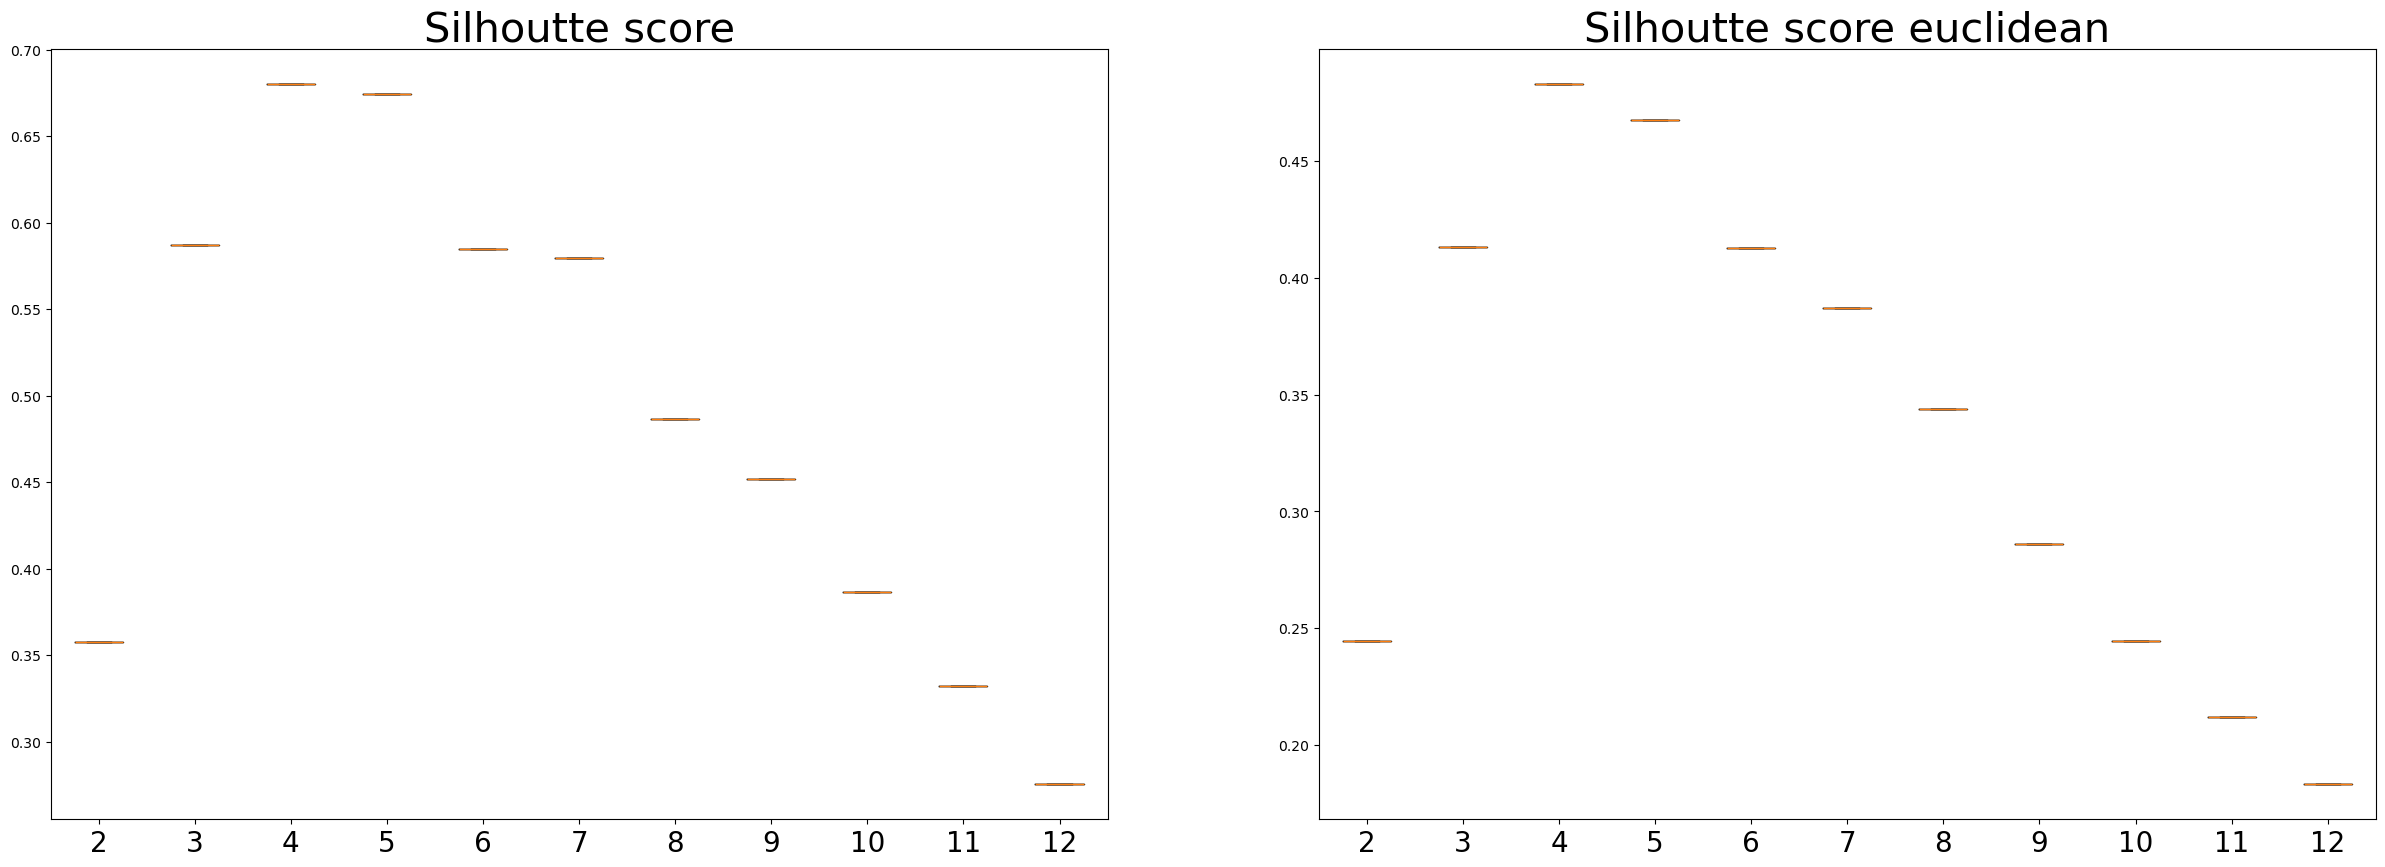

In [231]:
result_dict_spectral_rbf_l1 = {
    "Silhoutte score": [],
    "Silhoutte score euclidean": [],
}

for n_clusters in range(2, 13):
    print(f"Clusters: {n_clusters}")
    silhouettes = []
    silhouettes_euclidean = []
    for seed in range(50):
        kmeans = SpectralClustering(
            n_clusters=n_clusters,
            affinity="rbf",
            assign_labels="cluster_qr",
            gamma=1.5e-2,
            random_state=seed,
        ).fit(clonotype_count_df_l1)

        cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

        silhouette = silhouette_score(
            clonotype_count_df_l1, kmeans.labels_, metric="cosine"
        )

        silhouettes.append(silhouette)

        silhouette = silhouette_score(
            clonotype_count_df_l1, kmeans.labels_, metric="euclidean"
        )
        silhouettes_euclidean.append(silhouette)

    result_dict_spectral_rbf_l1["Silhoutte score"].append(silhouettes)
    result_dict_spectral_rbf_l1["Silhoutte score euclidean"].append(
        silhouettes_euclidean
    )

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(30, 10))

for i, (key, item) in enumerate(result_dict_spectral_rbf.items()):
    axes[i].boxplot(x=item)
    axes[i].set_title(key, fontsize=30)

    labels = [str(x) for x in range(2, 13)]
    axes[i].set_xticklabels(labels, fontsize=20)

Clusters: 2 : 0.40828016296702485
Clusters: 3 : 0.5671930170015193
Clusters: 4 : 0.6831352984928571
Clusters: 5 : 0.6654133345074951
Clusters: 6 : 0.6089883567163734
Clusters: 7 : 0.5889289638023075
Clusters: 8 : 0.5091792271575671
Clusters: 9 : 0.45312658041225257
Clusters: 10 : 0.36977996548473446
Clusters: 11 : 0.30567137894421337
Clusters: 12 : 0.30440570517561977


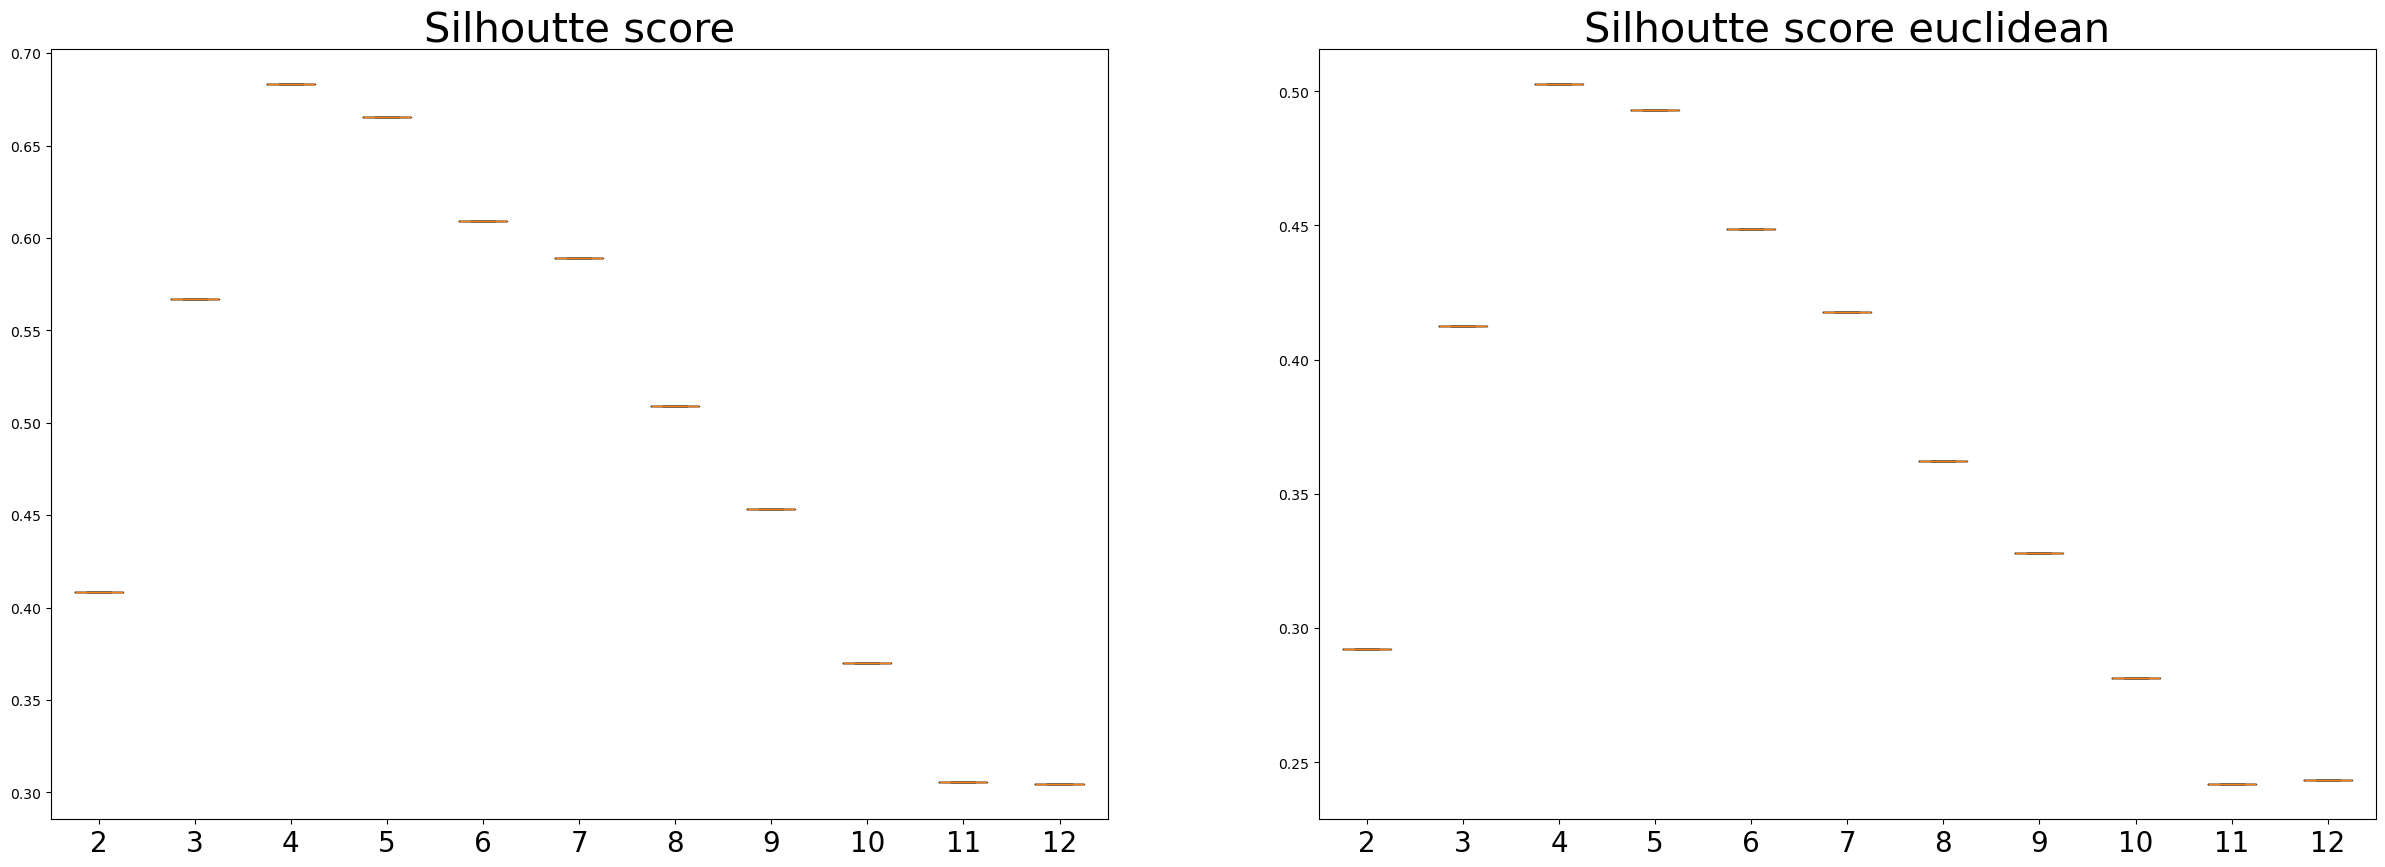

In [232]:
result_dict_spectral_cosine = {
    "Silhoutte score": [],
    "Silhoutte score euclidean": [],
}

for n_clusters in range(2, 13):

    silhouettes = []
    silhouettes_euclidean = []

    for seed in range(50):
        kmeans = SpectralClustering(
            n_clusters=n_clusters,
            affinity="precomputed",
            assign_labels="cluster_qr",
            random_state=seed,
        ).fit(similarity)

        cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

        silhouette = silhouette_score(
            clonotype_count_df_normed, kmeans.labels_, metric="cosine"
        )

        silhouettes.append(silhouette)

        silhouette = silhouette_score(
            clonotype_count_df_normed, kmeans.labels_, metric="euclidean"
        )

        silhouettes_euclidean.append(silhouette)

    result_dict_spectral_cosine["Silhoutte score"].append(silhouettes)
    result_dict_spectral_cosine["Silhoutte score euclidean"].append(
        silhouettes_euclidean
    )

    print(f"Clusters: {n_clusters} : {np.mean(silhouettes)}")

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(30, 10))

for i, (key, item) in enumerate(result_dict_spectral_cosine.items()):
    axes[i].boxplot(x=item)
    axes[i].set_title(key, fontsize=30)

    labels = [str(x) for x in range(2, 13)]
    axes[i].set_xticklabels(labels, fontsize=20)

In [235]:
# Aggregate results
clustering_df = pd.DataFrame(columns=["Value", "Algorithm", "Metric", "Clusters"])
for i, x in enumerate(range(2, 13)):

    for value in result_dict_spectral_cosine["Silhoutte score"][i]:
        clustering_df.loc[len(clustering_df)] = [value, "spectral_cosine", "cosine", x]

    for value in result_dict_spectral_cosine["Silhoutte score euclidean"][i]:
        clustering_df.loc[len(clustering_df)] = [
            value,
            "spectral_cosine",
            "euclidean",
            x,
        ]

    for value in result_dict_spectral_rbf_l1["Silhoutte score"][i]:
        clustering_df.loc[len(clustering_df)] = [value, "spectral_rbf_l1", "cosine", x]

    for value in result_dict_spectral_rbf_l1["Silhoutte score euclidean"][i]:
        clustering_df.loc[len(clustering_df)] = [
            value,
            "spectral_rbf_l1",
            "euclidean",
            x,
        ]

    for value in result_dict_spectral_rbf_l2["Silhoutte score"][i]:
        clustering_df.loc[len(clustering_df)] = [value, "spectral_rbf_l2", "cosine", x]

    for value in result_dict_spectral_rbf_l2["Silhoutte score euclidean"][i]:
        clustering_df.loc[len(clustering_df)] = [
            value,
            "spectral_rbf_l2",
            "euclidean",
            x,
        ]

    for value in result_dict_kmeans_l1["Silhoutte score"][i]:
        clustering_df.loc[len(clustering_df)] = [value, "kmeans_l1", "cosine", x]

    for value in result_dict_kmeans_l1["Silhoutte score euclidean"][i]:
        clustering_df.loc[len(clustering_df)] = [
            value,
            "kmeans_l1",
            "euclidean",
            x,
        ]

    for value in result_dict_kmeans_l2["Silhoutte score"][i]:
        clustering_df.loc[len(clustering_df)] = [value, "kmeans_l2", "cosine", x]

    for value in result_dict_kmeans_l2["Silhoutte score euclidean"][i]:
        clustering_df.loc[len(clustering_df)] = [
            value,
            "kmeans_l2",
            "euclidean",
            x,
        ]

    for value in result_dict_kmeans_ilr["Silhoutte score"][i]:
        clustering_df.loc[len(clustering_df)] = [value, "kmeans_ilr", "cosine", x]

    for value in result_dict_kmeans_ilr["Silhoutte score euclidean"][i]:
        clustering_df.loc[len(clustering_df)] = [
            value,
            "kmeans_ilr",
            "euclidean",
            x,
        ]

clustering_df.to_csv("clustering_silhouttes_dataframe.csv")

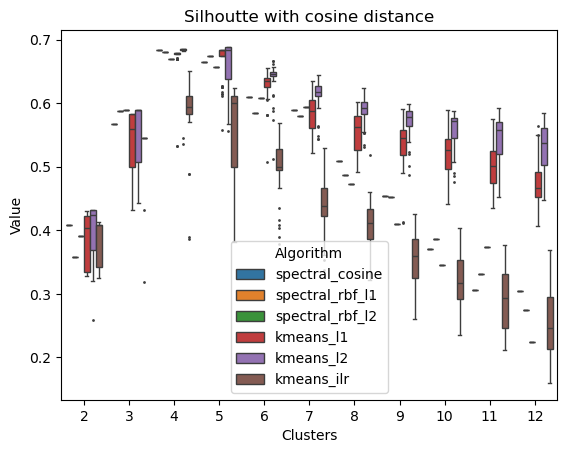

Text(0.5, 1.0, 'Silhoutte with euclidean distance')

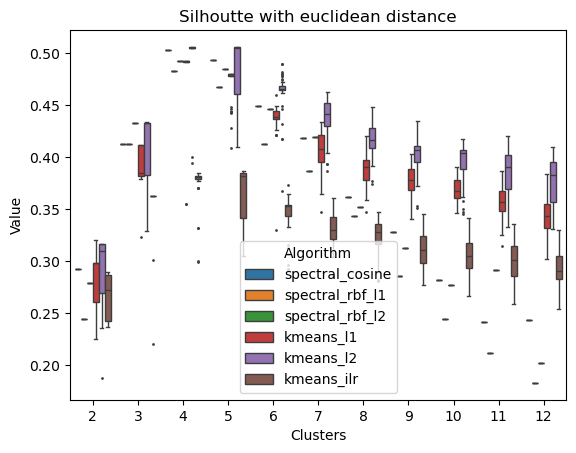

In [236]:
# Plot results
clustering_df.groupby(["Metric", "Algorithm", "Clusters"])
ax = sns.boxplot(
    clustering_df[clustering_df["Metric"] == "cosine"],
    x="Clusters",
    y="Value",
    hue="Algorithm",
    fliersize=1,
)

ax.set_title("Silhoutte with cosine distance")
plt.show()

ax1 = sns.boxplot(
    clustering_df[clustering_df["Metric"] == "euclidean"],
    x="Clusters",
    y="Value",
    hue="Algorithm",
    fliersize=1,
)

ax1.set_title("Silhoutte with euclidean distance")

In [286]:
# Generate tables from results 
clustering_df_filtered = clustering_df[
    (clustering_df["Clusters"] > 2) & (clustering_df["Clusters"] <= 10) #remove some values to make tabels more managable
]

In [287]:
clustering_df_filtered

,Value,Algorithm,Metric,Clusters
600,0.567193,spectral_cosine,cosine,3
601,0.567193,spectral_cosine,cosine,3
602,0.567193,spectral_cosine,cosine,3
603,0.567193,spectral_cosine,cosine,3
604,0.567193,spectral_cosine,cosine,3
...,...,...,...,...
5395,0.341770,kmeans_ilr,euclidean,10
5396,0.316914,kmeans_ilr,euclidean,10
5397,0.266982,kmeans_ilr,euclidean,10
5398,0.304806,kmeans_ilr,euclidean,10


In [288]:
# format results for display as latex table
# leave out some trials
clustering_df_filtered = clustering_df_filtered[
    (clustering_df["Clusters"] > 2) & (clustering_df["Clusters"] <= 10)
]

mean_df = (
    clustering_df_filtered[clustering_df_filtered["Metric"] == "cosine"]
    .loc[:, ["Value", "Algorithm", "Clusters"]]
    .groupby(["Algorithm", "Clusters"])
    .mean()
)

std_df = (
    clustering_df_filtered[clustering_df_filtered["Metric"] == "cosine"]
    .loc[:, ["Value", "Algorithm", "Clusters"]]
    .groupby(["Algorithm", "Clusters"])
    .std()
)

formatted_df = (
    mean_df.map(lambda x: "{:.2f}".format(round(x, 2)))
    + " ("
    + std_df.map(lambda x: "{:.2f}".format(round(x, 2)))
    + ")"
).unstack()
formatted_df

Value                                         \
Clusters                  3            4            5            6    
Algorithm                                                             
kmeans_ilr       0.54 (0.04)  0.59 (0.05)  0.56 (0.06)  0.50 (0.04)   
kmeans_l1        0.55 (0.04)  0.67 (0.03)  0.67 (0.03)  0.63 (0.02)   
kmeans_l2        0.56 (0.04)  0.68 (0.03)  0.66 (0.03)  0.64 (0.03)   
spectral_cosine  0.57 (0.00)  0.68 (0.00)  0.67 (0.00)  0.61 (0.00)   
spectral_rbf_l1  0.59 (0.00)  0.68 (0.00)  0.67 (0.00)  0.58 (0.00)   
spectral_rbf_l2  0.59 (0.00)  0.67 (0.00)  0.66 (0.00)  0.61 (0.00)   

                                                                     
Clusters                  7            8            9            10  
Algorithm                                                            
kmeans_ilr       0.44 (0.04)  0.41 (0.04)  0.36 (0.04)  0.32 (0.04)  
kmeans_l1        0.58 (0.03)  0.56 (0.03)  0.54 (0.03)  0.52 (0.03)  
kmeans_l2        0.61 (0.02)  0.59 (0.02)  0.57 (0.02)  0.56 (0.03)  
spectral_cosine  0.59 (0.00)  0.51 (0.00)  0.45 (0.00)  0.37 (0.00)  
spectral_rbf_l1  0.58 (0.00)  0.49 (0.00)  0.45 (0.00)  0.39 (0.00)  
spectral_rbf_l2  0.59 (0.00)  0.47 (0.00)  0.41 (0.00)  0.35 (0.00)

In [289]:
print(formatted_df.to_latex(column_format="|l|m{1cm}" + "|m{1cm}" * 10 + "|"))

\begin{tabular}{|l|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|}
\toprule
 & \multicolumn{8}{r}{Value} \\
Clusters & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\
Algorithm &  &  &  &  &  &  &  &  \\
\midrule
kmeans_ilr & 0.54 (0.04) & 0.59 (0.05) & 0.56 (0.06) & 0.50 (0.04) & 0.44 (0.04) & 0.41 (0.04) & 0.36 (0.04) & 0.32 (0.04) \\
kmeans_l1 & 0.55 (0.04) & 0.67 (0.03) & 0.67 (0.03) & 0.63 (0.02) & 0.58 (0.03) & 0.56 (0.03) & 0.54 (0.03) & 0.52 (0.03) \\
kmeans_l2 & 0.56 (0.04) & 0.68 (0.03) & 0.66 (0.03) & 0.64 (0.03) & 0.61 (0.02) & 0.59 (0.02) & 0.57 (0.02) & 0.56 (0.03) \\
spectral_cosine & 0.57 (0.00) & 0.68 (0.00) & 0.67 (0.00) & 0.61 (0.00) & 0.59 (0.00) & 0.51 (0.00) & 0.45 (0.00) & 0.37 (0.00) \\
spectral_rbf_l1 & 0.59 (0.00) & 0.68 (0.00) & 0.67 (0.00) & 0.58 (0.00) & 0.58 (0.00) & 0.49 (0.00) & 0.45 (0.00) & 0.39 (0.00) \\
spectral_rbf_l2 & 0.59 (0.00) & 0.67 (0.00) & 0.66 (0.00) & 0.61 (0.00) & 0.59 (0.00) & 0.47 (0.00) & 0.41 (0.00) & 0.35 (0.00) \\
\

In [290]:
# format results for display as latex table
# leave out some trials
clustering_df_filtered = clustering_df_filtered[
    (clustering_df["Clusters"] > 2) & (clustering_df["Clusters"] <= 10)
]

mean_df = (
    clustering_df_filtered[clustering_df_filtered["Metric"] == "euclidean"]
    .loc[:, ["Value", "Algorithm", "Clusters"]]
    .groupby(["Algorithm", "Clusters"])
    .mean()
)

std_df = (
    clustering_df_filtered[clustering_df_filtered["Metric"] == "euclidean"]
    .loc[:, ["Value", "Algorithm", "Clusters"]]
    .groupby(["Algorithm", "Clusters"])
    .std()
)

formatted_df = (
    mean_df.map(lambda x: "{:.2f}".format(round(x, 2)))
    + " ("
    + std_df.map(lambda x: "{:.2f}".format(round(x, 2)))
    + ")"
).unstack()
print(formatted_df.to_latex(column_format="|l|m{1cm}" + "|m{1cm}" * 10 + "|"))

\begin{tabular}{|l|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|m{1cm}|}
\toprule
 & \multicolumn{8}{r}{Value} \\
Clusters & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\
Algorithm &  &  &  &  &  &  &  &  \\
\midrule
kmeans_ilr & 0.36 (0.02) & 0.38 (0.02) & 0.36 (0.02) & 0.35 (0.02) & 0.33 (0.02) & 0.32 (0.02) & 0.31 (0.02) & 0.31 (0.02) \\
kmeans_l1 & 0.40 (0.02) & 0.49 (0.03) & 0.47 (0.02) & 0.44 (0.02) & 0.41 (0.02) & 0.39 (0.02) & 0.38 (0.01) & 0.37 (0.01) \\
kmeans_l2 & 0.41 (0.03) & 0.50 (0.02) & 0.49 (0.03) & 0.46 (0.02) & 0.44 (0.02) & 0.42 (0.02) & 0.40 (0.02) & 0.40 (0.02) \\
spectral_cosine & 0.41 (0.00) & 0.50 (0.00) & 0.49 (0.00) & 0.45 (0.00) & 0.42 (0.00) & 0.36 (0.00) & 0.33 (0.00) & 0.28 (0.00) \\
spectral_rbf_l1 & 0.41 (0.00) & 0.48 (0.00) & 0.47 (0.00) & 0.41 (0.00) & 0.39 (0.00) & 0.34 (0.00) & 0.29 (0.00) & 0.24 (0.00) \\
spectral_rbf_l2 & 0.43 (0.00) & 0.49 (0.00) & 0.49 (0.00) & 0.45 (0.00) & 0.42 (0.00) & 0.35 (0.00) & 0.31 (0.00) & 0.28 (0.00) \\
\

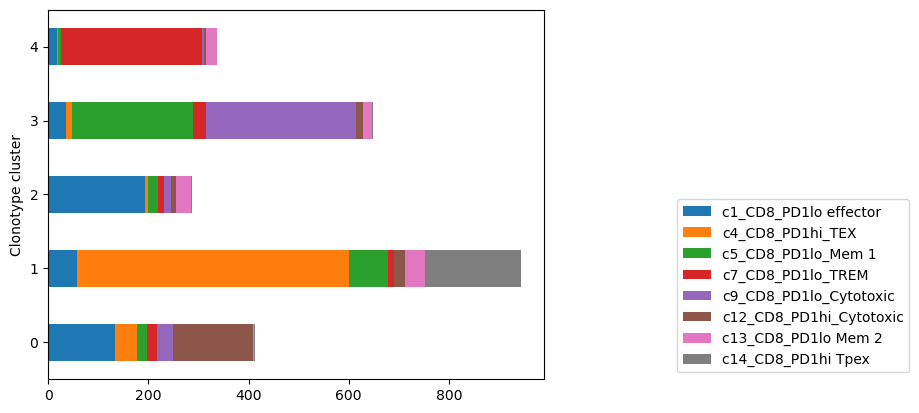

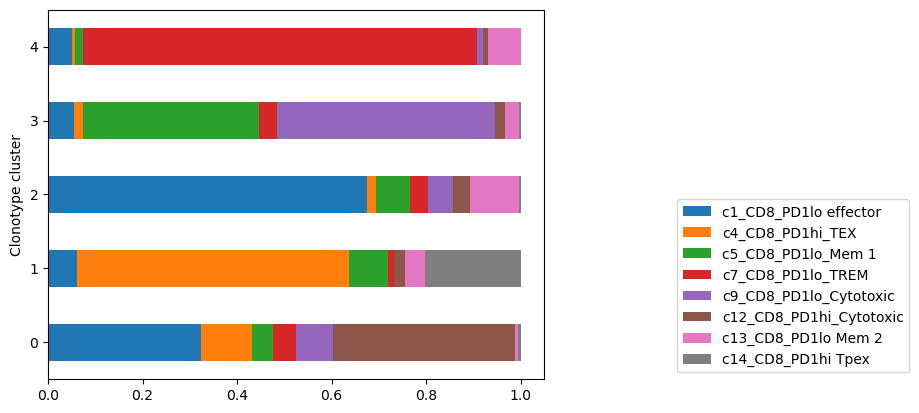

0.6883839609427127


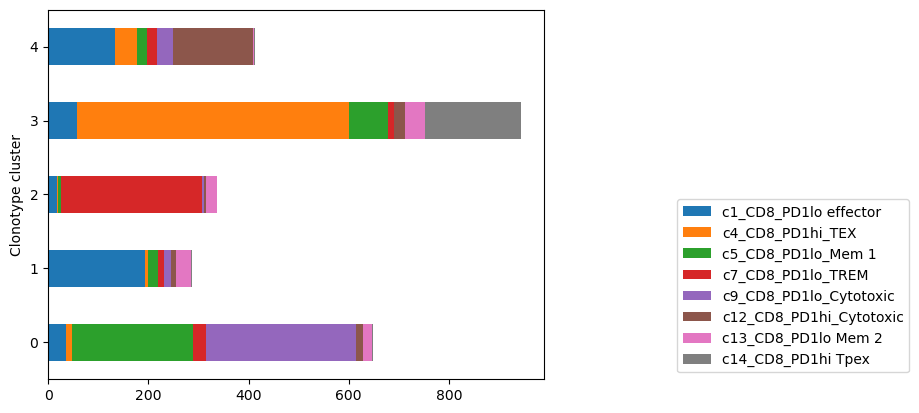

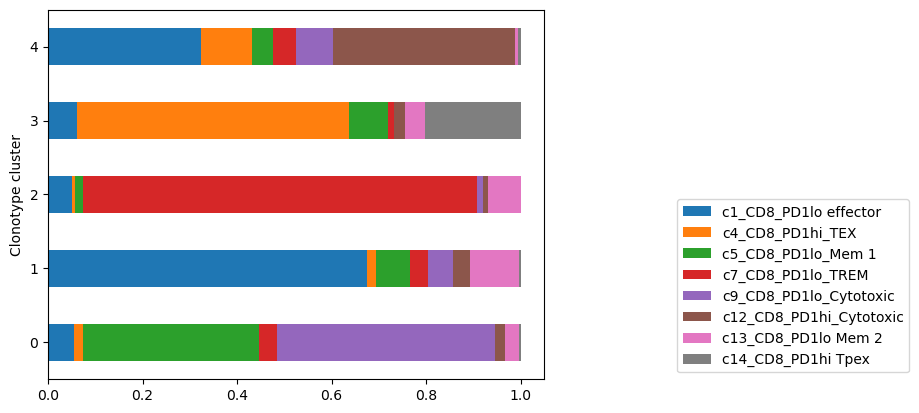

0.6883839609427127


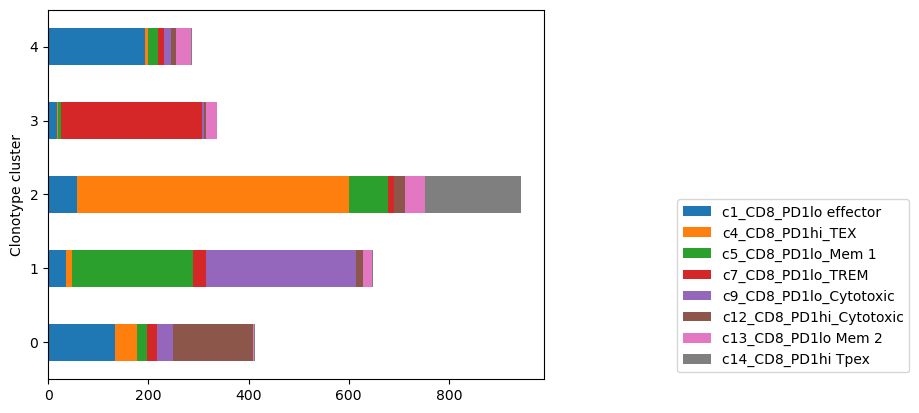

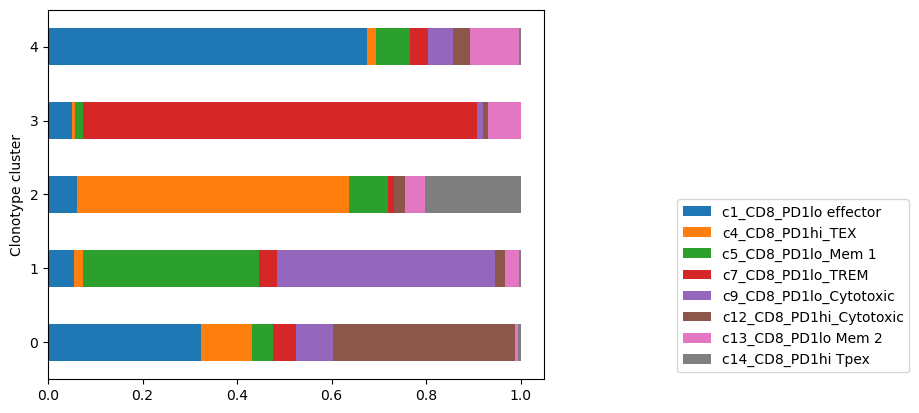

0.6883839609427127


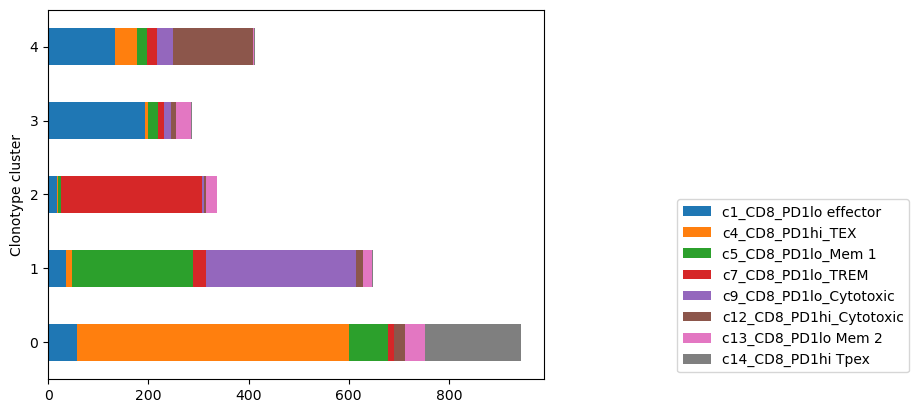

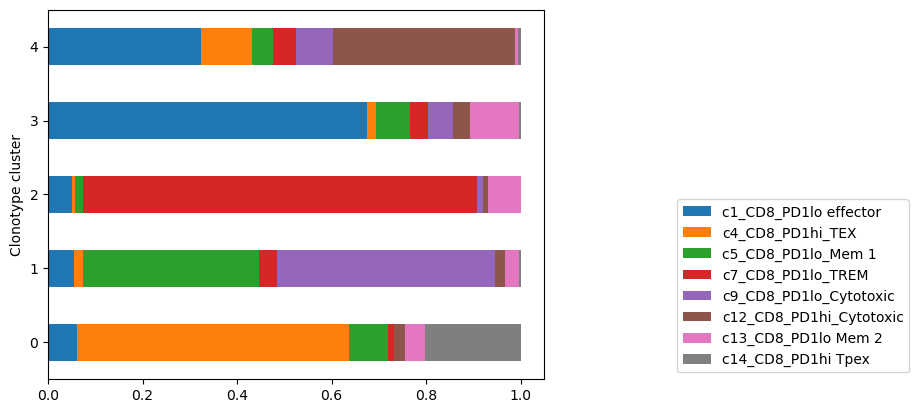

0.6883839609427127


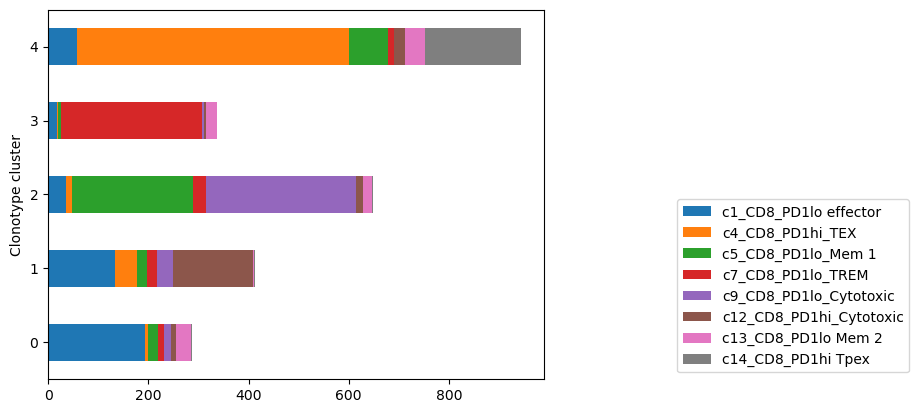

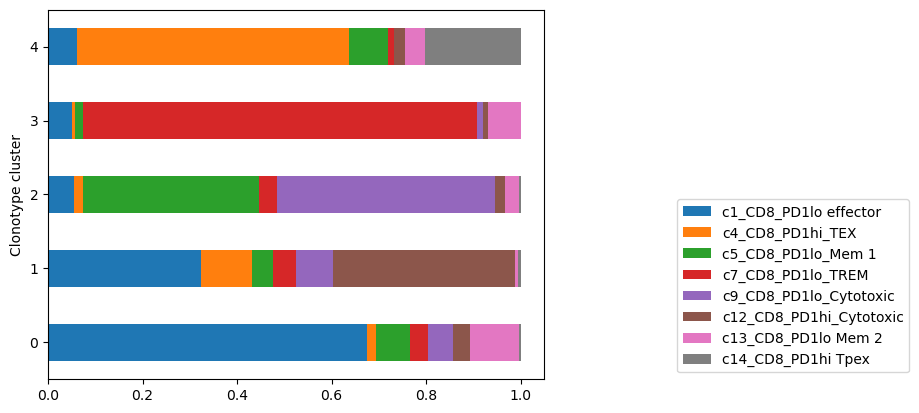

0.6883839609427127


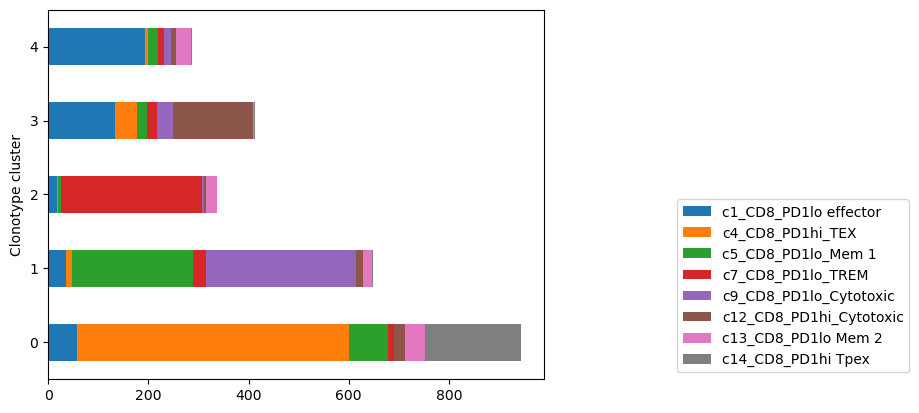

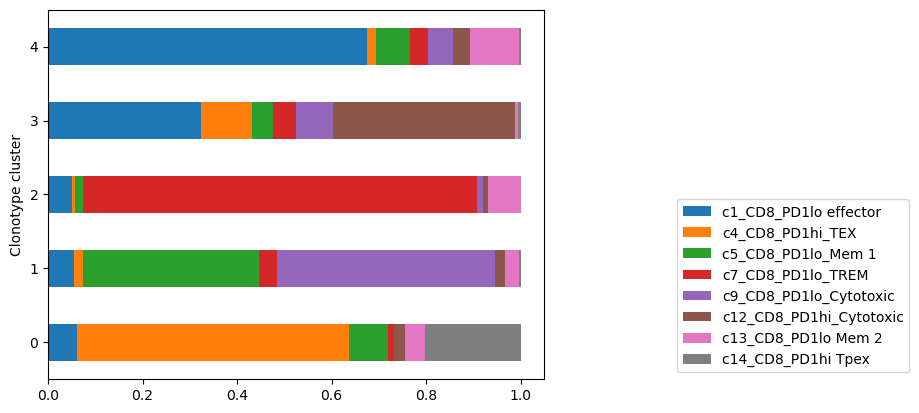

0.6883839609427127


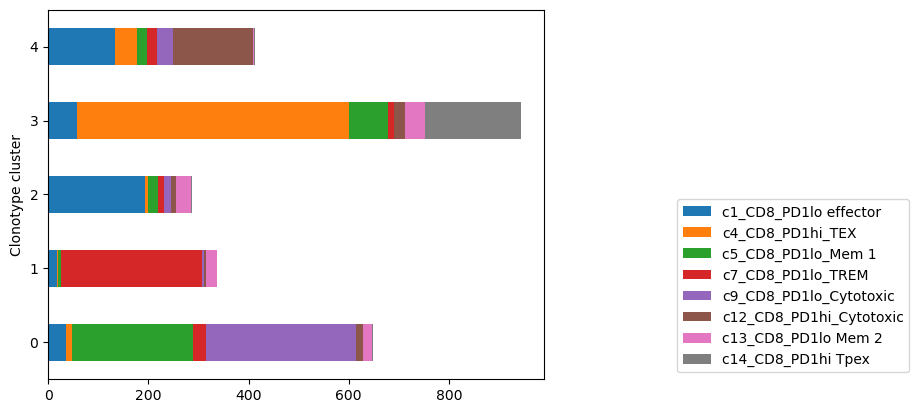

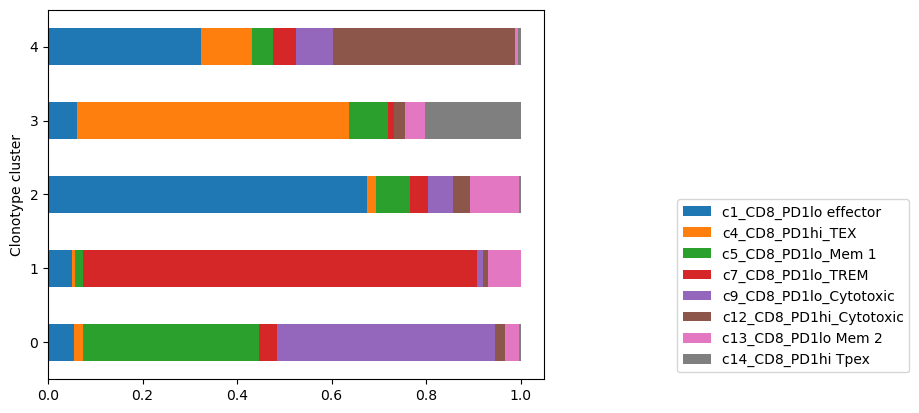

0.6883839609427127


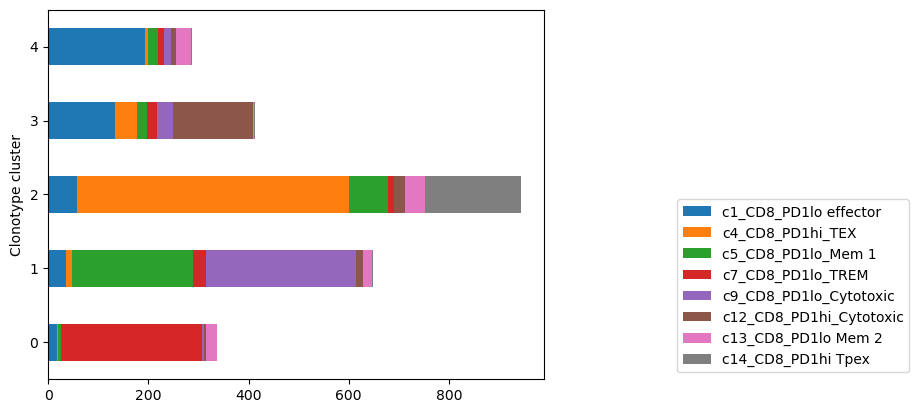

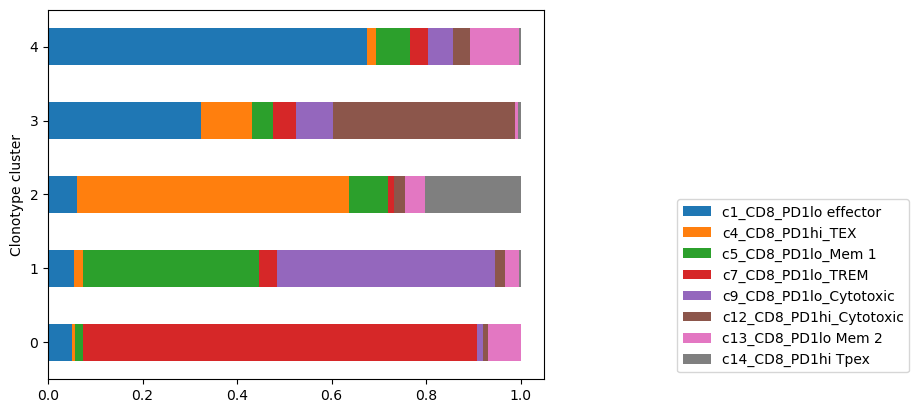

0.6883839609427127


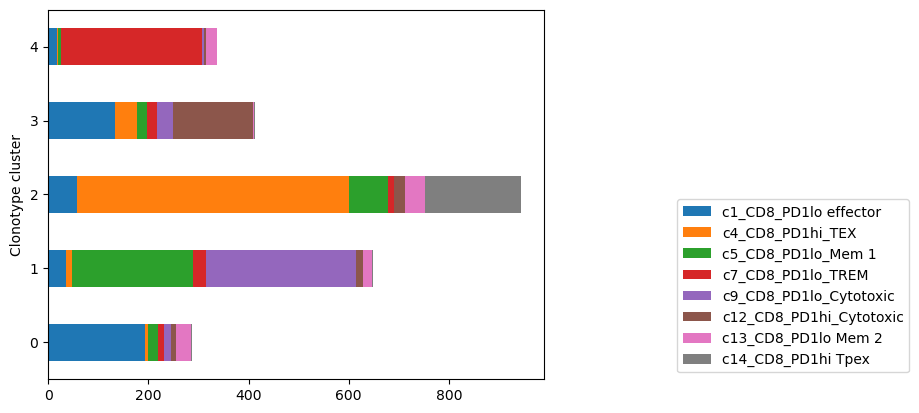

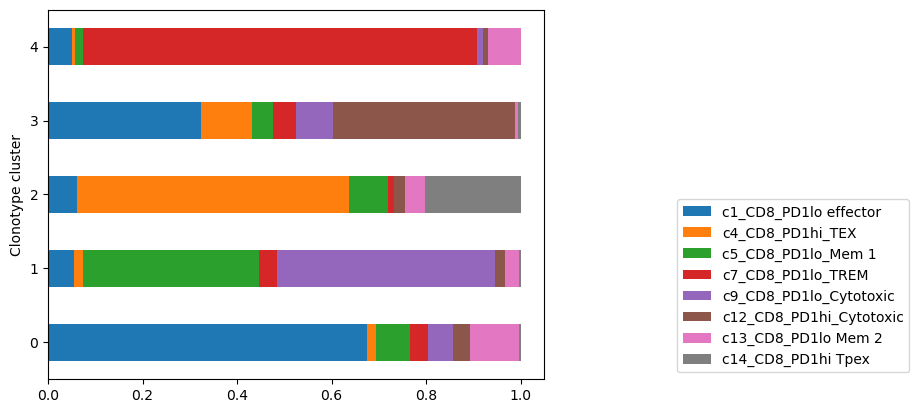

0.6883839609427127


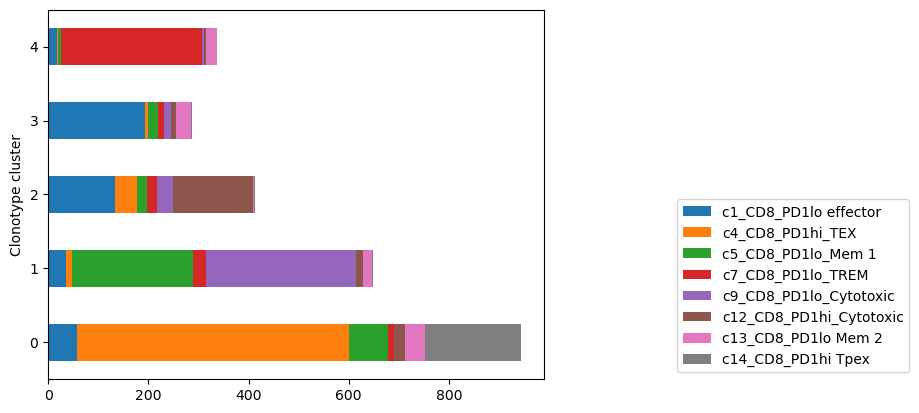

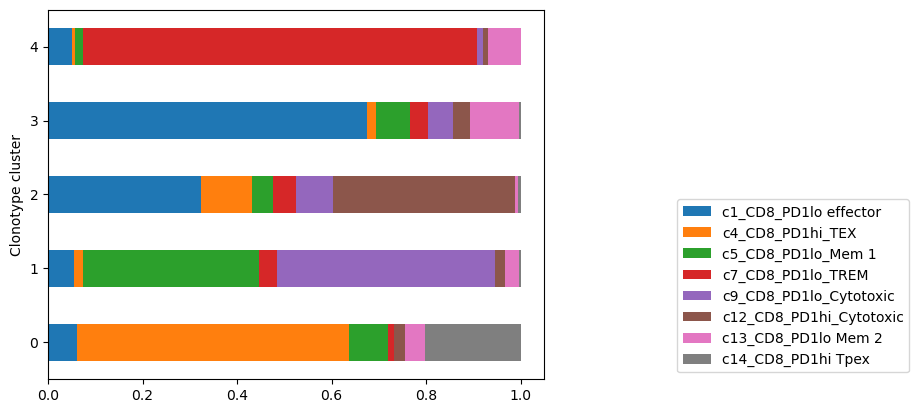

0.6883839609427127


In [38]:
n_clusters = 5
for seed in range(10):
    adata.obs["Clonotype cluster"] = pd.NA

    kmeans = run_and_plot_clustering(
        data=clonotype_count_df_normed,
        method="kmeans",
        n_clusters=n_clusters,
        seed=seed,
    )

    silhouette_avg = silhouette_score(
        clonotype_count_df, kmeans.labels_, metric="cosine"
    )
    print(silhouette_avg)

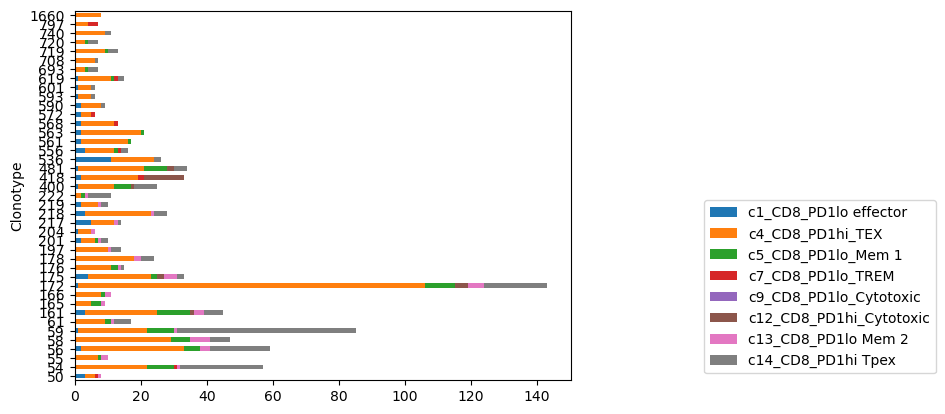

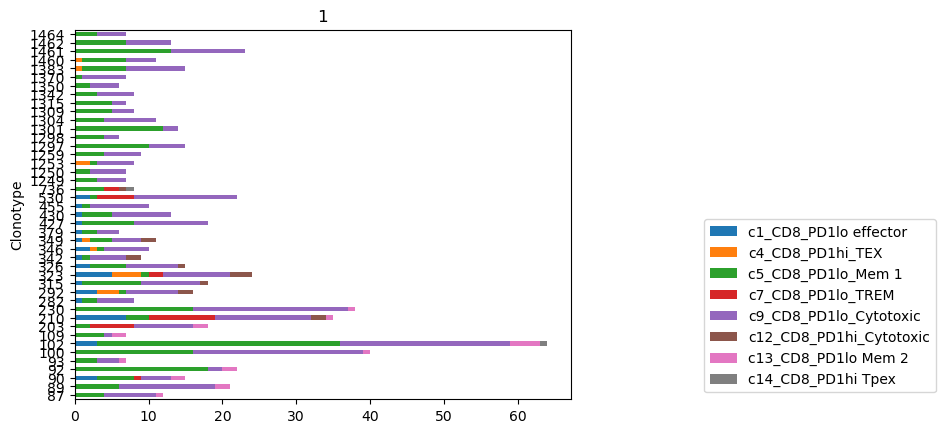

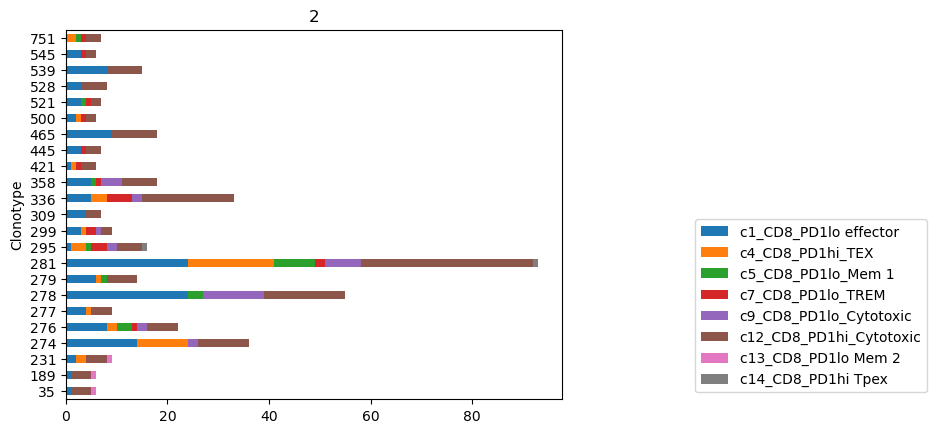

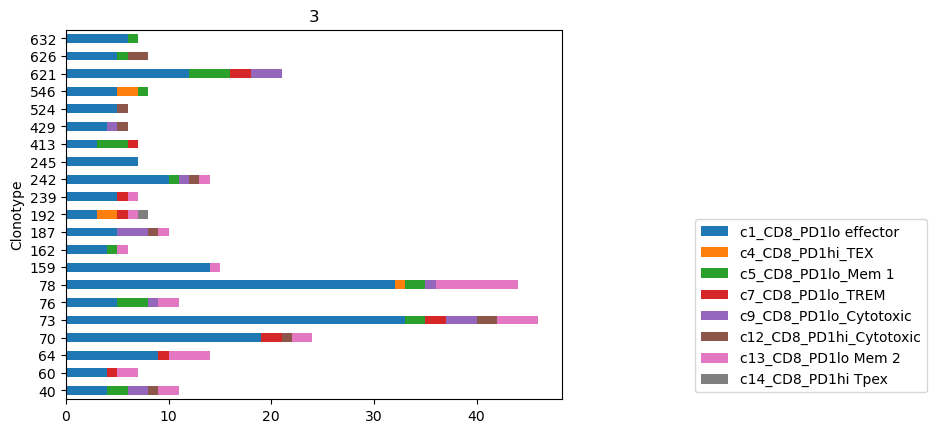

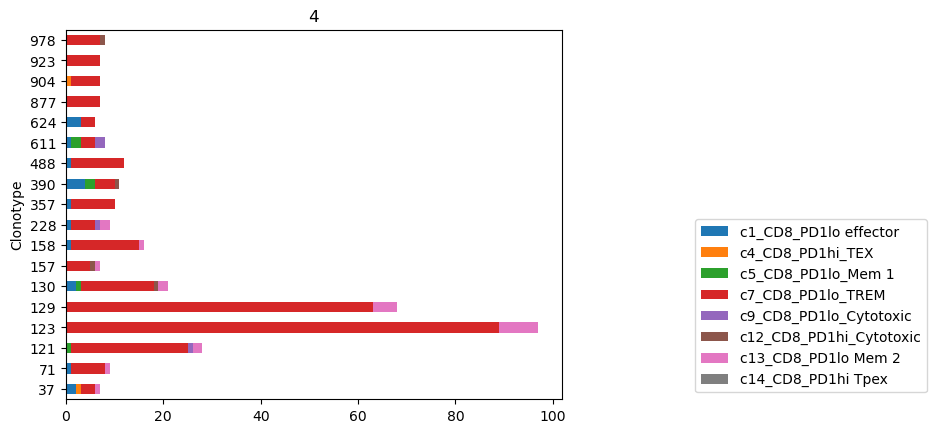

In [40]:
for label in np.unique(kmeans.labels_):

    clonotype_count_df.loc[kmeans.labels_ == label].plot.barh(stacked=True, title=label)
    plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
    plt.show()

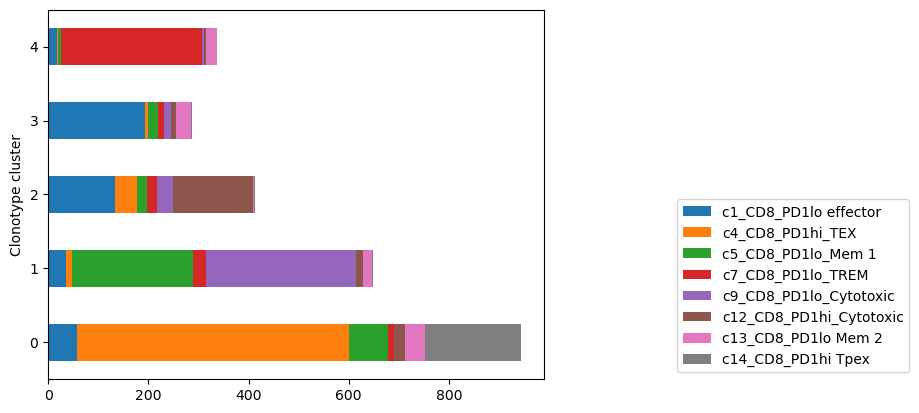

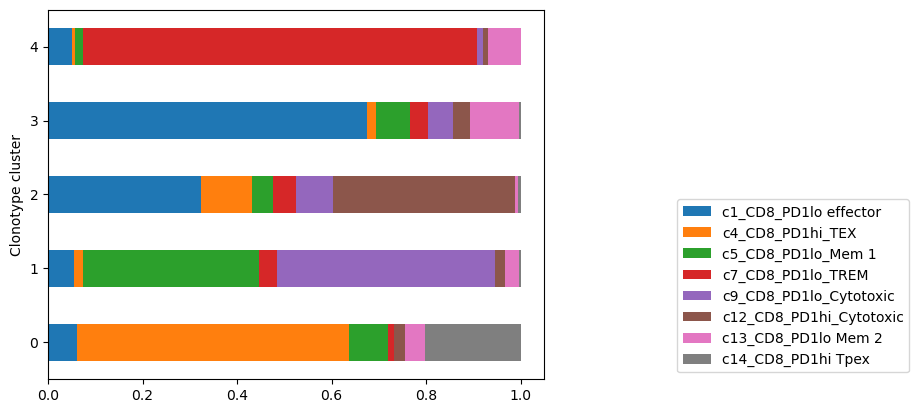

In [42]:
count_df_ = (
    adata.obs.value_counts(["Clonotype cluster", "Cluster label"])
    .reset_index()
    .pivot(index="Clonotype cluster", columns="Cluster label", values="count")
).fillna(0)
count_df_.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

In [43]:
adata.obs["Clonotype cluster"] = adata.obs["Clonotype cluster"].astype("category")

# Rename clonotype clusters  
adata.obs["Clonotype cluster"] = adata.obs["Clonotype cluster"].cat.rename_categories(
    {
        -1: "-1",
        4: "TREM",
        0: "Texh",
        3: "Mixed",
        2: "Eff/Cyto",
        1: "Cyto/Mem",
    }
)

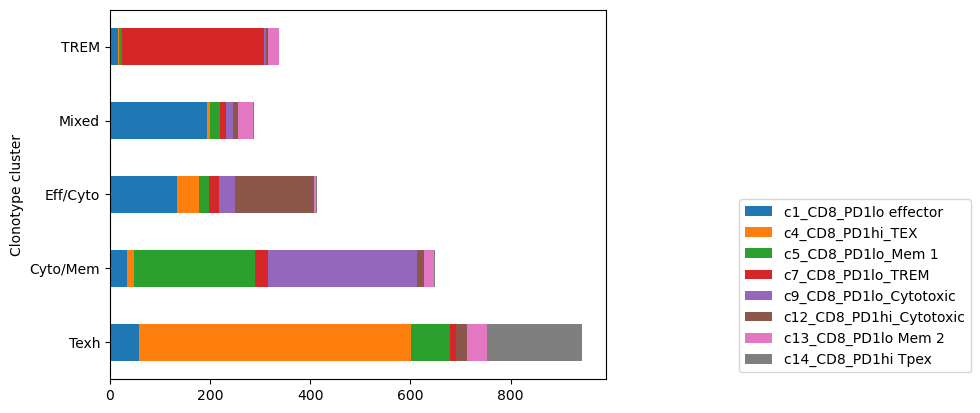

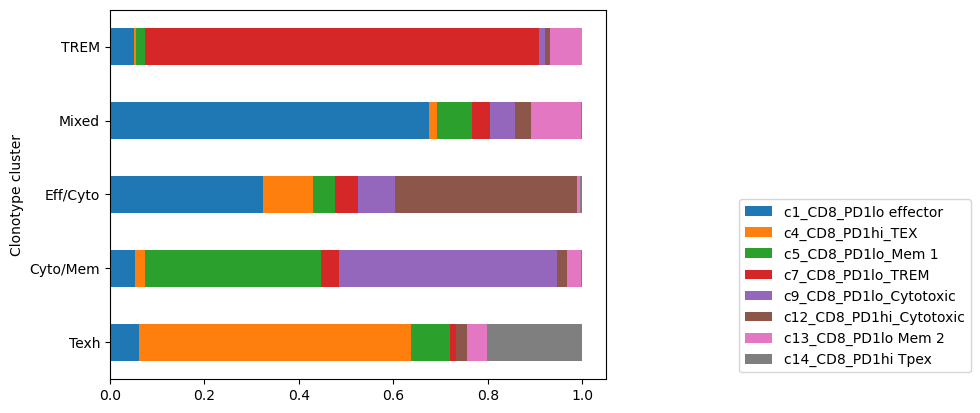

In [44]:
count_df_ = (
    adata[adata.obs["Clonotype cluster"] != "-1"]
    .obs.value_counts(["Cluster label", "Clonotype cluster"])
    .reset_index()
    .pivot(index="Clonotype cluster", columns="Cluster label", values="count")
).fillna(0)
count_df_.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

In [154]:
adata.obs["Clonotype cluster"].to_csv("clonotype_clusters_kmeans_5_clusters_good.csv")